# Assignment: Bike rentals prediction

## Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
from dataclasses import dataclass
from functools import partial
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, PredefinedSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, log_loss, r2_score, classification_report, mean_squared_error
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from astropy.visualization import hist
import scipy.stats as stats
from scipy.cluster import hierarchy
import warnings


plt.style.use('default')
warnings.filterwarnings("ignore")

## Python packages and machine specs

In [6]:
!python --version
!pip list | grep 'scikit\|seaborn\|scipy\|numpy\|pandas\|matplotlib'
!lscpu
!free -m

Python 3.7.12
matplotlib                    3.2.2
matplotlib-inline             0.1.3
matplotlib-venn               0.11.6
numpy                         1.19.5
pandas                        1.1.5
pandas-datareader             0.9.0
pandas-gbq                    0.13.3
pandas-profiling              1.4.1
scikit-image                  0.18.3
scikit-learn                  1.0.1
scipy                         1.4.1
seaborn                       0.11.2
sklearn-pandas                1.8.0
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cach

## Dataset

### Import dataset

In [7]:
DATASET_PATH = './Dataset.csv'
initial_df = pd.read_csv(DATASET_PATH)


### Check dataset info

In [8]:
initial_df.info()
initial_df.describe()
print(initial_df.head(10))
print(initial_df.tail(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           17379 non-null  int64  
 1   instant              17379 non-null  int64  
 2   date                 17379 non-null  object 
 3   season               17379 non-null  object 
 4   year                 17379 non-null  int64  
 5   month                17379 non-null  object 
 6   hour                 17379 non-null  int64  
 7   weekday              17379 non-null  object 
 8   weather              17379 non-null  object 
 9   temperature          17379 non-null  float64
 10  feeling_temperature  17379 non-null  float64
 11  humidity             17379 non-null  float64
 12  windspeed            17379 non-null  float64
 13  Subscribed           17379 non-null  int64  
 14  Non-subscribed       17379 non-null  int64  
 15  Total                17379 non-null 

### Declare dataset columns

In [9]:
UNNAMED = 'Unnamed: 0'
INSTANT = 'instant'
DATE = 'date'
SEASON = 'season'
YEAR = 'year'
MONTH = 'month'
HOUR = 'hour'
WEEKDAY = 'weekday'
WEATHER = 'weather'
TEMPERATURE = 'temperature'
FEELING_TEMPERATURE = 'feeling_temperature'
HUMIDITY = 'humidity'
WINDSPEED = 'windspeed'
SUBSCRIBED = 'Subscribed'
NON_SUBSCRIBED = 'Non-subscribed'
TOTAL = 'Total'

CATEGORICAL_COLUMNS = [
  SEASON,
  YEAR,
  MONTH,
  HOUR,
  WEEKDAY,
  WEATHER
]
CONTINUOUS_COLUMNS = [
  TEMPERATURE,
  FEELING_TEMPERATURE,
  HUMIDITY,
  WINDSPEED,
]

### Observations on dataset columns
Based on the above:
- It seems that 'Unnamed: 0' and 'instant' columns are related to the index of each sample,
so they can be safely dropped as they do not add any useful information.
- 'Subscribed' and 'Non-subscribed' seem to be the dependent variables, while 'Total' is
their sum.

As a result, the following dataframes are created from the initial dataset:


### Functions to split dataset to independent and dependent variables

In [10]:
def total_rentals_from(df):
  return df.filter(items=[TOTAL])

def subscribed_rentals_from(df):
  return df.filter(items=[SUBSCRIBED])

def non_subscribed_rentals_from(df):
  return df.filter(items=[NON_SUBSCRIBED])

def features_from(df):
  return df[df.columns.difference([TOTAL, SUBSCRIBED, NON_SUBSCRIBED])]


### Exclude date column

In [11]:
input_df = initial_df.drop(
  [INSTANT, UNNAMED, DATE],
  axis='columns'
)

## Data visualization

### Histograms

#### histogram plotting functions

In [12]:
def histogram_based_on_bayesian_blocks(data, column_name, ax):
  hist(data, bins='blocks', ax=ax, histtype='stepfilled', density=True)
  ax.set_title('Histogram of column: ' + column_name)
  return ax

def histogram_of_discrete_column(data, column_name, ax):
  presented_data = [entry.replace(' ', '\n') if type(entry) == str else entry for entry in data]
  ax.bar(*np.unique(presented_data, return_counts=True))
  ax.set_title('Histogram of discrete column: ' + column_name)
  return ax

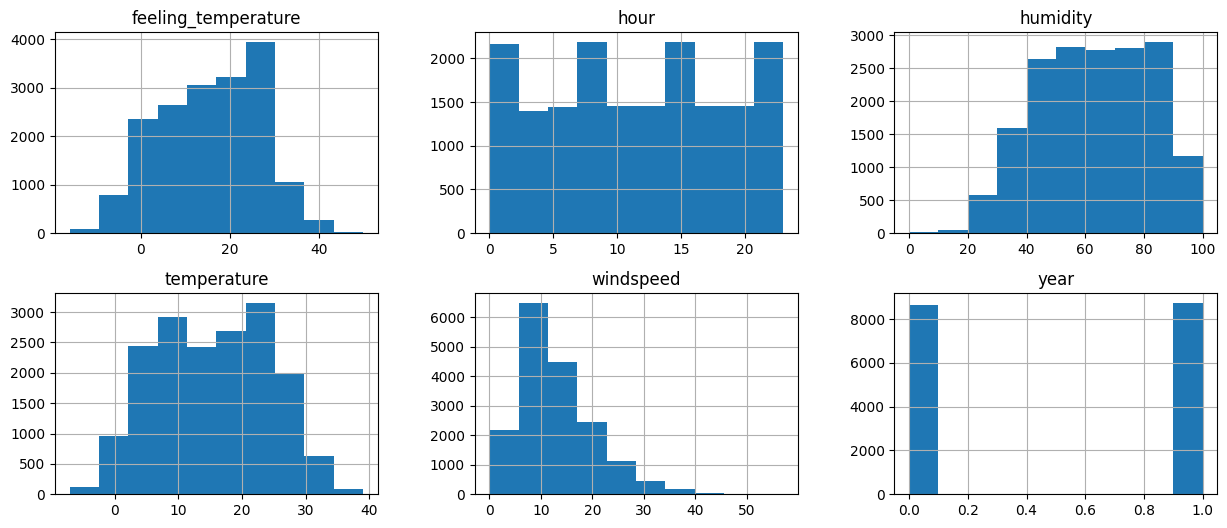

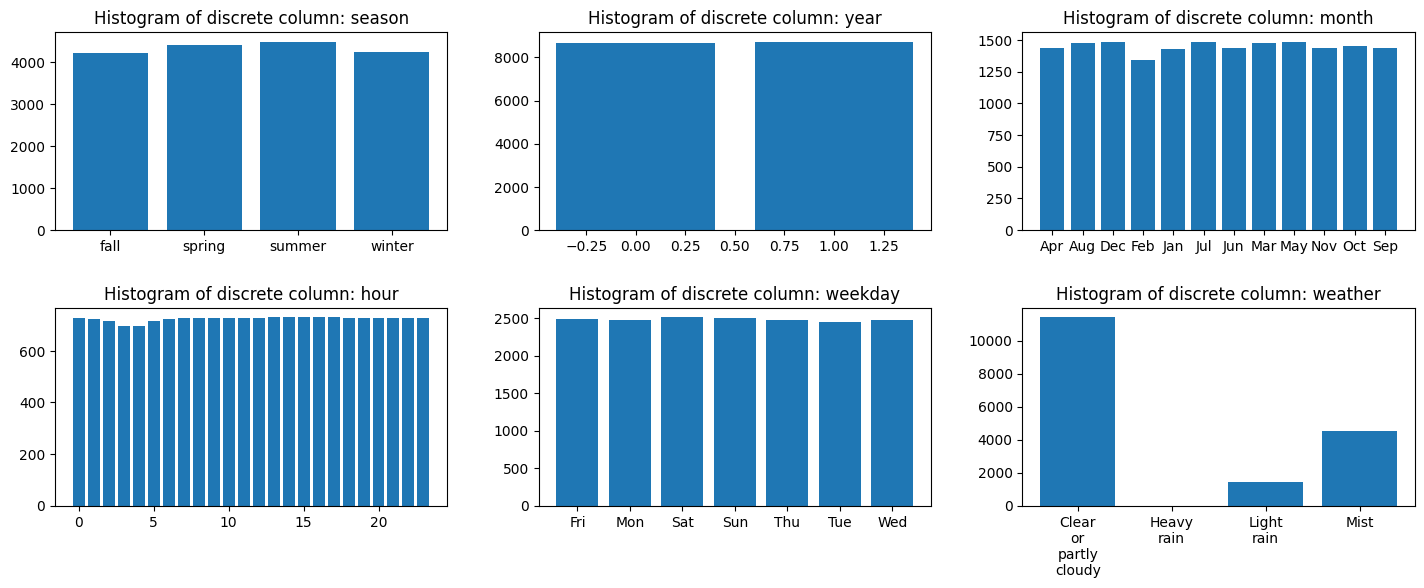

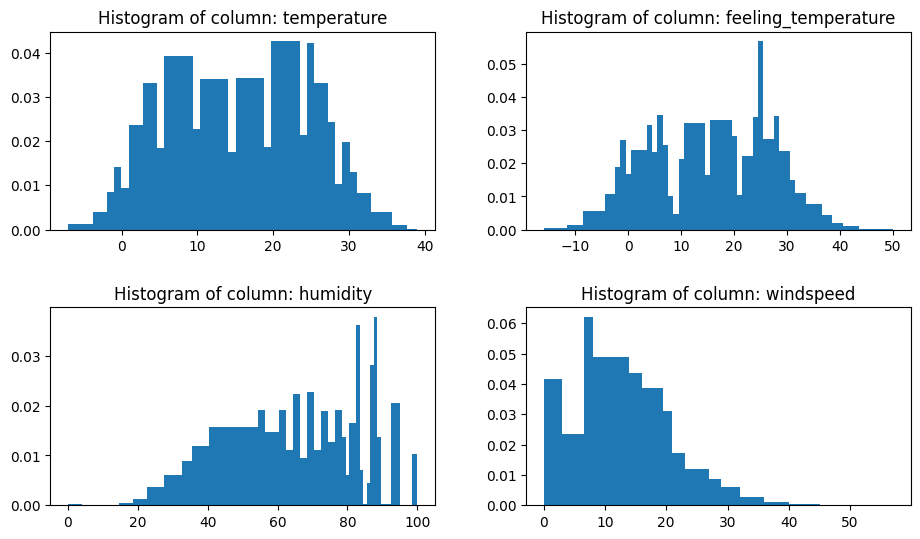

In [13]:
features_from(input_df).hist(layout=(2,3), figsize=(15, 6))

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
fig.tight_layout(pad=3.5)
for i, ax in enumerate(axs.reshape(-1)):
  histogram_of_discrete_column(input_df[CATEGORICAL_COLUMNS[i]], CATEGORICAL_COLUMNS[i], ax)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.tight_layout(pad=3.5)
for i, ax in enumerate(axs.reshape(-1)):
  histogram_based_on_bayesian_blocks(input_df[CONTINUOUS_COLUMNS[i]], CONTINUOUS_COLUMNS[i], ax)

### Boxplots and Correlation

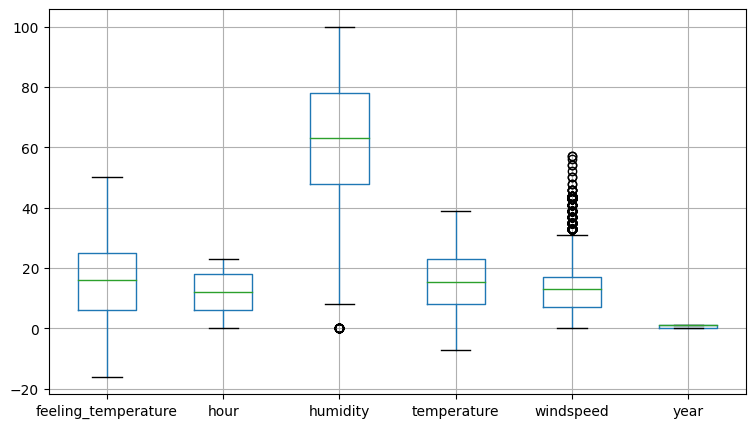

In [14]:
features_from(input_df).boxplot(figsize=(9, 5))

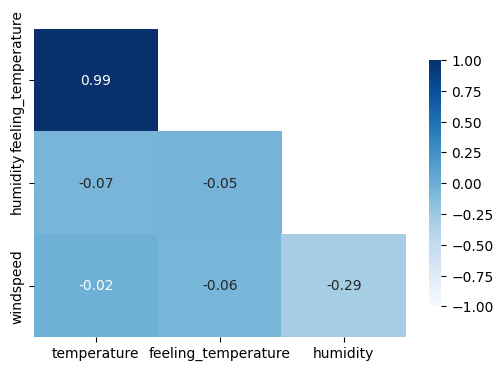

In [15]:
def plot_correlation(correlation_matrix, ax):
  mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
  mask = mask[1:, :-1]
  corr = correlation_matrix.iloc[1:, :-1].copy()  # plot heatmap
  sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
             vmin=-1, vmax=1, cbar_kws={"shrink": .8}, ax=ax)  # yticks

correlation_matrix = input_df[CONTINUOUS_COLUMNS].corr()
fig, ax = plt.subplots(figsize=(6, 4))
plot_correlation(correlation_matrix, ax)

Text(0, 0.5, 'feeling_temperature')

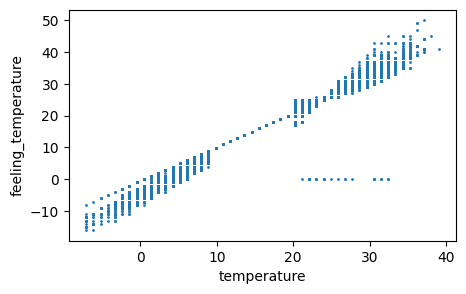

In [16]:
# Relation between temperature and feeling temperature
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(input_df[TEMPERATURE], input_df[FEELING_TEMPERATURE], s=1)
ax.set_xlabel('temperature')
ax.set_ylabel('feeling_temperature')

### Dependent variables according to individual features

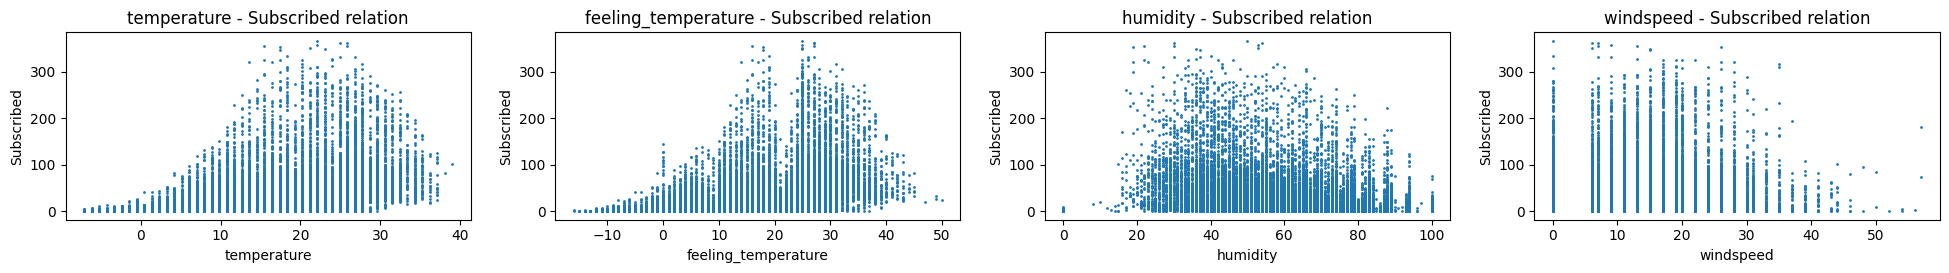

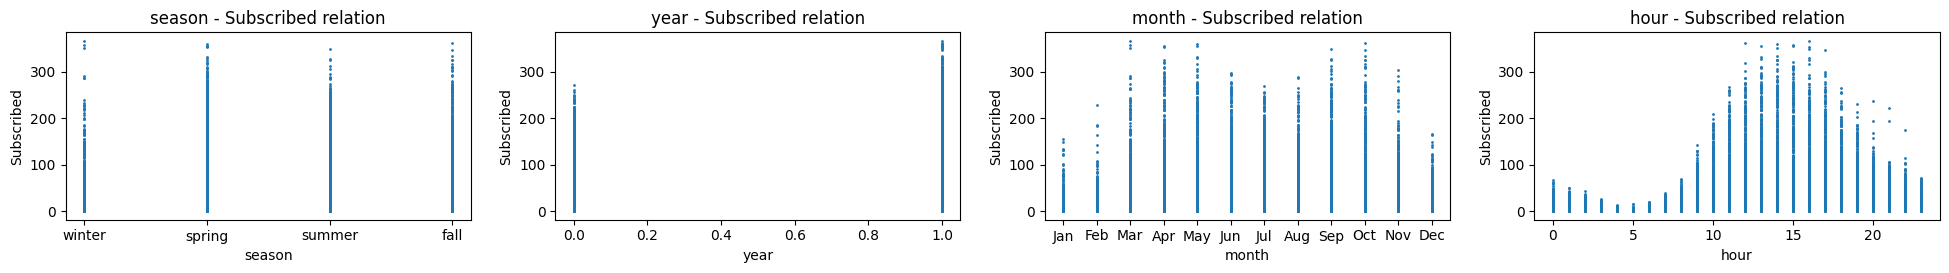

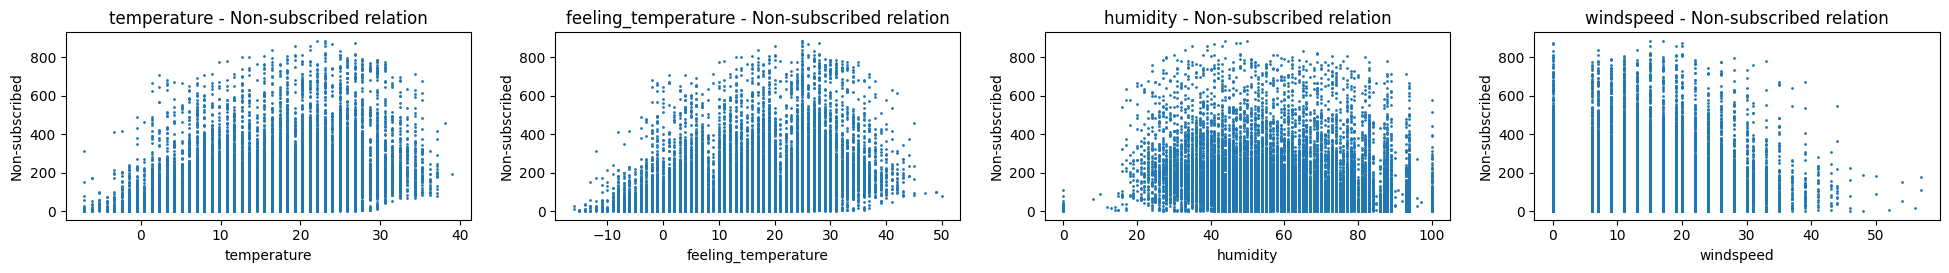

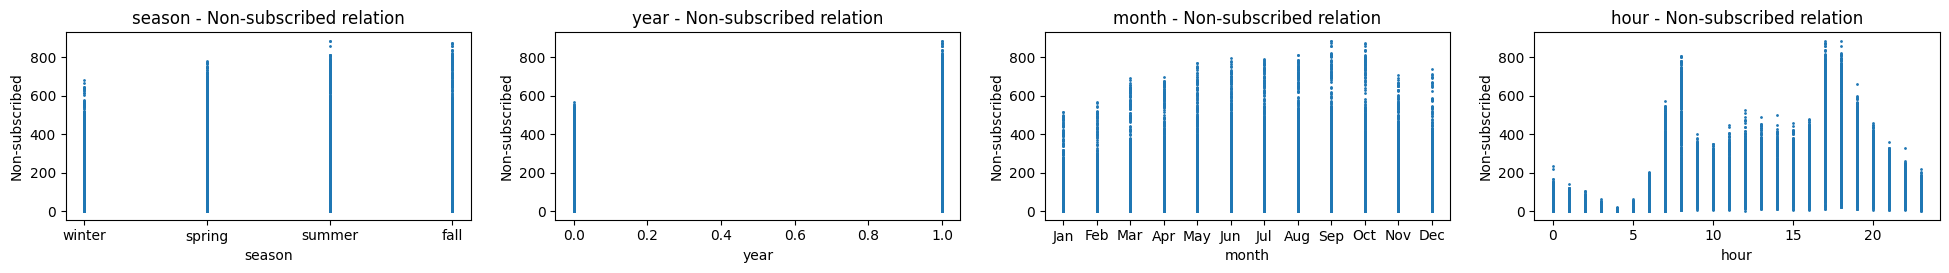

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
fig.tight_layout(pad=3.0)
for index, ax in enumerate(axs.reshape(-1)):
  ax.scatter(input_df[CONTINUOUS_COLUMNS[index]], subscribed_rentals_from(input_df), s=1)
  ax.set_title(f'{CONTINUOUS_COLUMNS[index]} - {SUBSCRIBED} relation')
  ax.set_xlabel(CONTINUOUS_COLUMNS[index])
  ax.set_ylabel(SUBSCRIBED)

fig, axs = plt.subplots(1, 4, figsize=(20, 3))
fig.tight_layout(pad=3.0)
for index, ax in enumerate(axs.reshape(-1)):
  ax.scatter(input_df[CATEGORICAL_COLUMNS[index]], subscribed_rentals_from(input_df), s=1)
  ax.set_title(f'{CATEGORICAL_COLUMNS[index]} - {SUBSCRIBED} relation')
  ax.set_xlabel(CATEGORICAL_COLUMNS[index])
  ax.set_ylabel(SUBSCRIBED)

fig, axs = plt.subplots(1, 4, figsize=(20, 3))
fig.tight_layout(pad=3.0)
for index, ax in enumerate(axs.reshape(-1)):
  ax.scatter(input_df[CONTINUOUS_COLUMNS[index]], non_subscribed_rentals_from(input_df), s=1)
  ax.set_title(f'{CONTINUOUS_COLUMNS[index]} - {NON_SUBSCRIBED} relation')
  ax.set_xlabel(CONTINUOUS_COLUMNS[index])
  ax.set_ylabel(NON_SUBSCRIBED)

fig, axs = plt.subplots(1, 4, figsize=(20, 3))
fig.tight_layout(pad=3.0)
for index, ax in enumerate(axs.reshape(-1)):
  ax.scatter(input_df[CATEGORICAL_COLUMNS[index]], non_subscribed_rentals_from(input_df), s=1)
  ax.set_title(f'{CATEGORICAL_COLUMNS[index]} - {NON_SUBSCRIBED} relation')
  ax.set_xlabel(CATEGORICAL_COLUMNS[index])
  ax.set_ylabel(NON_SUBSCRIBED)

### Distributions of features

#### helper functions for approximating distributions

In [18]:
DISTRIBUTIONS = ['weibull_min', 'norm', 'weibull_max', 
                 'uniform', 'gamma', 'expon',
                 'lognorm', 'pearson3', 'triang', 'gennorm']


In [19]:
def best_fitted_distribution_for(data, bins=100):
  hist, bin_edges = np.histogram(data, bins=bins, density=True)
  bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0

  sum_square_error_per_distribution = {}

  for distribution_name in DISTRIBUTIONS:
    distribution = getattr(stats, distribution_name)

    parameters = distribution.fit(data)
    pdf = distribution.pdf(bin_edges, *parameters)
    sum_square_error = np.sum(np.power(hist - pdf, 2.0))
    sum_square_error_per_distribution[distribution_name] = sum_square_error

  best_distribution = min(
    sum_square_error_per_distribution,
    key=sum_square_error_per_distribution.get
  )

  return {
    'name': best_distribution,
    'distribution': getattr(stats, best_distribution),
    'parameters': parameters,
    'square_error': sum_square_error_per_distribution[best_distribution]
  }

def make_pdf(dist, params, size=10000):
  # Separate parts of parameters
  arg = params[:-2]
  loc = params[-2]
  scale = params[-1]

  # Get start and end points of distribution
  start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
  end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

  # Build PDF and turn into pandas Series
  x = np.linspace(start, end, size)
  y = dist.pdf(x, loc=loc, scale=scale, *arg)
  pdf = pd.Series(y, x)

  return pdf

#### Approximate distributions of quantitative columns

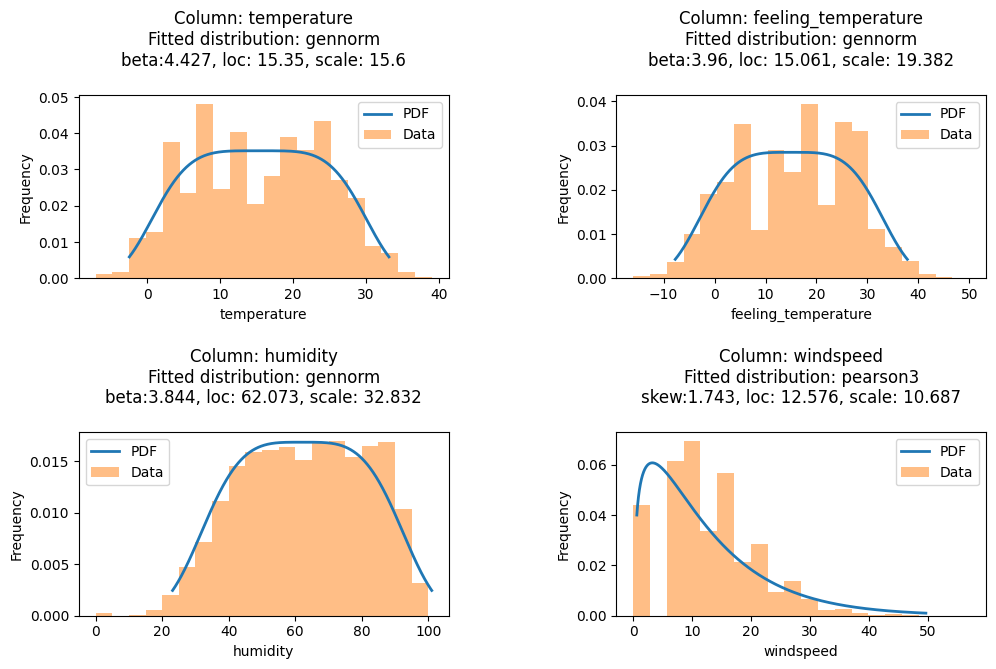

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=9)

for i, ax in enumerate(axs.reshape(-1)):
  data = input_df[CONTINUOUS_COLUMNS[i]]

  fitted_distribution = best_fitted_distribution_for(data, 30)
  pdf = make_pdf(fitted_distribution['distribution'], fitted_distribution['parameters'])
  params = tuple([float("{0:.3f}".format(n)) for n in fitted_distribution["parameters"]])
  ax.set_title(f'Column: {CONTINUOUS_COLUMNS[i]}\n'
               f'Fitted distribution: {fitted_distribution["name"]}\n'
              #  f'parameters: {fitted_distribution["parameters"]}\n'
               f'{"skew" if fitted_distribution["name"] == "pearson3" else "beta"}:{params[0]}, '
               f'loc: {params[1]}, '
               f'scale: {params[2]}\n'
              #  f'parameters: {tuple([float("{0:.3f}".format(n)) for n in fitted_distribution["parameters"]])}\n'
  )
  ax.set_xlabel(CONTINUOUS_COLUMNS[i])
  pdf.plot(lw=2, label='PDF', legend=True, ax=ax)
  data.plot(kind='hist', bins=20, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

## Feature engineering

### Missing values
After running the following command we observe that there are no null values in our data

In [21]:
def print_null_and_inf(df):
  print(f'Number of null values per column\n{np.sum(df.isnull())}\n')
  print(f'Number of NaN values per column\n{np.sum(df.isna())}\n')
  print(f'Number of inf values per column\n{np.sum(np.isinf(df[CONTINUOUS_COLUMNS]))}\n')

print_null_and_inf(input_df)

Number of null values per column
season                 0
year                   0
month                  0
hour                   0
weekday                0
weather                0
temperature            0
feeling_temperature    0
humidity               0
windspeed              0
Subscribed             0
Non-subscribed         0
Total                  0
dtype: int64

Number of NaN values per column
season                 0
year                   0
month                  0
hour                   0
weekday                0
weather                0
temperature            0
feeling_temperature    0
humidity               0
windspeed              0
Subscribed             0
Non-subscribed         0
Total                  0
dtype: int64

Number of inf values per column
temperature            0
feeling_temperature    0
humidity               0
windspeed              0
dtype: int64



### Task B.3: Outliers

In [22]:
CAPPING_THRESHOLD_LOWER = 0.01
CAPPING_THRESHOLD_UPPER = 0.99

def print_outliers_of(df):
  quantile_of_upper_threshold = df[map(lambda x: x, CONTINUOUS_COLUMNS)].quantile(CAPPING_THRESHOLD_UPPER)
  quantile_of_lower_threshold = df[map(lambda x: x, CONTINUOUS_COLUMNS)].quantile(CAPPING_THRESHOLD_LOWER)

  print(
    pd.DataFrame([
      ((df < quantile_of_lower_threshold) | (df > quantile_of_upper_threshold)).sum(),
      ((df < quantile_of_upper_threshold) & (df > quantile_of_lower_threshold)).sum()
    ],
      index=['Rows out of quantiles', 'Rows between quantiles']
    ).transpose()
  )

print_outliers_of(input_df)

                     Rows out of quantiles  Rows between quantiles
Non-subscribed                           0                       0
Subscribed                               0                       0
Total                                    0                       0
feeling_temperature                    254                   16974
hour                                     0                       0
humidity                               148                   16915
month                                    0                       0
season                                   0                       0
temperature                            291                   17012
weather                                  0                       0
weekday                                  0                       0
windspeed                              146                   14969
year                                     0                       0


In [23]:
def cap_data(df, columns, lower_threshold=CAPPING_THRESHOLD_LOWER, upper_threshold=CAPPING_THRESHOLD_UPPER):
  columns_index = pd.Index(columns)
  df[columns_index] = df[columns_index].clip(
    df[columns_index].quantile(lower_threshold),
    df[columns_index].quantile(upper_threshold),
    axis=1
  )
  return df

df_for_training = cap_data(input_df, map(lambda x: x, CONTINUOUS_COLUMNS))
print_outliers_of(df_for_training)

                     Rows out of quantiles  Rows between quantiles
Non-subscribed                           0                       0
Subscribed                               0                       0
Total                                    0                       0
feeling_temperature                      0                   16974
hour                                     0                       0
humidity                                 0                   16915
month                                    0                       0
season                                   0                       0
temperature                            174                   17012
weather                                  0                       0
weekday                                  0                       0
windspeed                                0                   14969
year                                     0                       0


### Additional feature columns

In [24]:
# class Feature(Enum):
SEASON_SIN = 'season_sin'
SEASON_COS = 'season_cos'
SEASON_SUMMER = 'season_summer'
SEASON_WINTER = 'season_winter'
SEASON_FALL = 'season_fall'
SEASON_SPRING = 'season_spring'
YEAR = 'year'
MONTH_SIN = 'month_sin'
MONTH_COS = 'month_cos'
MONTH_JAN = "month_Jan"
MONTH_FEB = "month_Feb"
MONTH_MAR = "month_Mar"
MONTH_APR = "month_Apr"
MONTH_MAY = "month_May"
MONTH_JUN = "month_Jun"
MONTH_JUL = "month_Jul"
MONTH_AUG = "month_Aug"
MONTH_SEP = "month_Sep"
MONTH_OCT = "month_Oct"
MONTH_NOV = "month_Nov"
MONTH_DEC = "month_Dec"
HOUR_SIN = 'hour_sin'
HOUR_COS = 'hour_cos'
HOUR_0 = 'hour_0'
HOUR_1 = 'hour_1'
HOUR_2 = 'hour_2'
HOUR_3 = 'hour_3'
HOUR_4 = 'hour_4'
HOUR_5 = 'hour_5'
HOUR_6 = 'hour_6'
HOUR_7 = 'hour_7'
HOUR_8 = 'hour_8'
HOUR_9 = 'hour_9'
HOUR_10 = 'hour_10'
HOUR_11 = 'hour_11'
HOUR_12 = 'hour_12'
HOUR_13 = 'hour_13'
HOUR_14 = 'hour_14'
HOUR_15 = 'hour_15'
HOUR_16 = 'hour_16'
HOUR_17 = 'hour_17'
HOUR_18 = 'hour_18'
HOUR_19 = 'hour_19'
HOUR_20 = 'hour_20'
HOUR_21 = 'hour_21'
HOUR_22 = 'hour_22'
HOUR_23 = 'hour_23'
WEEKDAY_SIN = 'weekday_sin'
WEEKDAY_COS = 'weekday_cos'
WEEKDAY_MON = 'weekday_Mon'
WEEKDAY_TUE = 'weekday_Tue'
WEEKDAY_WED = 'weekday_Wed'
WEEKDAY_THU = 'weekday_Thu'
WEEKDAY_FRI = 'weekday_Fri'
WEEKDAY_SAT = 'weekday_Sat'
WEEKDAY_SUN = 'weekday_Sun'
WEATHER_CLEAR_OR_CLOUDY = 'weather_Clear or partly cloudy'
WEATHER_HEAVY_RAIN = 'weather_Heavy rain'
WEATHER_LIGHT_RAIN = 'weather_Light rain'
WEATHER_MIST = 'weather_Mist'
TEMPERATURE = 'temperature'
FEELING_TEMPERATURE = 'feeling_temperature'
HUMIDITY = 'humidity'
WINDSPEED = 'windspeed'

### One hot encoding

In [25]:
df_for_training = pd.concat([df_for_training, pd.get_dummies(df_for_training[WEATHER], prefix=WEATHER)], axis=1)
df_for_training.drop([WEATHER, WEATHER_HEAVY_RAIN], axis=1, inplace=True)

df_for_training = pd.concat([df_for_training, pd.get_dummies(df_for_training[HOUR], prefix=HOUR)], axis=1)
df_for_training.drop([HOUR, HOUR_0], axis=1, inplace=True)

df_for_training = pd.concat([df_for_training, pd.get_dummies(df_for_training[MONTH], prefix=MONTH)], axis=1)
df_for_training.drop([MONTH, MONTH_DEC], axis=1, inplace=True)

df_for_training = pd.concat([df_for_training, pd.get_dummies(df_for_training[WEEKDAY], prefix=WEEKDAY)], axis=1)
df_for_training.drop([WEEKDAY, WEEKDAY_SUN], axis=1, inplace=True)

df_for_training = pd.concat([df_for_training, pd.get_dummies(df_for_training[SEASON], prefix=SEASON)], axis=1)
df_for_training.drop([SEASON, SEASON_WINTER], axis=1, inplace=True)

input_df = pd.concat([input_df, pd.get_dummies(input_df[WEATHER], prefix=WEATHER)], axis=1)
input_df.drop([WEATHER, WEATHER_HEAVY_RAIN], axis=1, inplace=True)

input_df = pd.concat([input_df, pd.get_dummies(input_df[HOUR], prefix=HOUR)], axis=1)
input_df.drop([HOUR, HOUR_0], axis=1, inplace=True)

input_df = pd.concat([input_df, pd.get_dummies(input_df[MONTH], prefix=MONTH)], axis=1)
input_df.drop([MONTH, MONTH_DEC], axis=1, inplace=True)

input_df = pd.concat([input_df, pd.get_dummies(input_df[WEEKDAY], prefix=WEEKDAY)], axis=1)
input_df.drop([WEEKDAY, WEEKDAY_SUN], axis=1, inplace=True)

input_df = pd.concat([input_df, pd.get_dummies(input_df[SEASON], prefix=SEASON)], axis=1)
input_df.drop([SEASON, SEASON_WINTER], axis=1, inplace=True) 

### Encoding cyclical features
Encoding of cyclical features was not applied in the end. 
Results seem to be better when one-hot encoding is applied, so the code of this section was commented out.

#### Hours

In [26]:
# print(f'Unique HOURS: {df_for_training[HOUR].unique()}')
# unique_hours = df_for_training[HOUR].nunique()
# df_for_training[HOUR_SIN] = np.sin(df_for_training[HOUR] * (2. * np.pi / unique_hours))
# df_for_training[HOUR_COS] = np.cos(df_for_training[HOUR] * (2. * np.pi / unique_hours))
# df_for_training.drop([HOUR], axis=1, inplace=True)


#### Months

In [27]:
# print(f'Unique months: {df_for_training[MONTH].unique()}')
# unique_months = df_for_training[MONTH].nunique()
# months_indexes = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9,
#                   'Nov': 10, 'Dec': 11}
# df_for_training[MONTH] = df_for_training[MONTH].map(months_indexes)
# df_for_training[MONTH_SIN] = np.sin((df_for_training[MONTH]) * (2. * np.pi / unique_months))
# df_for_training[MONTH_COS] = np.cos((df_for_training[MONTH]) * (2. * np.pi / unique_months))
# df_for_training.drop([MONTH], axis=1, inplace=True)

#### Weekdays

In [28]:
# print(f'Unique weekdays: {df_for_training[WEEKDAY].unique()}')
# unique_weekdays = df_for_training[WEEKDAY].nunique()
# weekday_indexes = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
# df_for_training[WEEKDAY] = df_for_training[WEEKDAY].map(weekday_indexes)
# df_for_training[WEEKDAY_SIN] = np.sin((df_for_training[WEEKDAY]) * (2. * np.pi / unique_weekdays))
# df_for_training[WEEKDAY_COS] = np.cos((df_for_training[WEEKDAY]) * (2. * np.pi / unique_weekdays))
# df_for_training.drop([WEEKDAY], axis=1, inplace=True)

#### Seasons

In [29]:
# print(f'Unique seasons: {df_for_training[SEASON].unique()}')
# unique_seasons = df_for_training[SEASON].nunique()
# seasons_indexes = {'winter': 0, 'spring': 1, 'summer': 2, 'fall': 3}
# df_for_training[SEASON] = df_for_training[SEASON].map(seasons_indexes)
# df_for_training[SEASON_SIN] = np.sin((df_for_training[SEASON]) * (2. * np.pi / unique_seasons))
# df_for_training[SEASON_COS] = np.cos((df_for_training[SEASON]) * (2. * np.pi / unique_seasons))
# df_for_training.drop([SEASON], axis=1, inplace=True)

### Label Encoding
Label encoding was not applied in the end. Results seem to be better when one-hot encoding is applied, so the code of this section was commented out.

In [30]:
# from sklearn.preprocessing import LabelEncoder

# label_enc = LabelEncoder()

# df_for_training[WEATHER] = label_enc.fit_transform(df_for_training[WEATHER])
# df_for_training[MONTH] = label_enc.fit_transform(df_for_training[MONTH])
# df_for_training[WEEKDAY] = label_enc.fit_transform(df_for_training[WEEKDAY])
# df_for_training[SEASON] = label_enc.fit_transform(df_for_training[SEASON])

### Check processed dataset

In [31]:
print_null_and_inf(df_for_training)

Number of null values per column
year                              0
temperature                       0
feeling_temperature               0
humidity                          0
windspeed                         0
Subscribed                        0
Non-subscribed                    0
Total                             0
weather_Clear or partly cloudy    0
weather_Light rain                0
weather_Mist                      0
hour_1                            0
hour_2                            0
hour_3                            0
hour_4                            0
hour_5                            0
hour_6                            0
hour_7                            0
hour_8                            0
hour_9                            0
hour_10                           0
hour_11                           0
hour_12                           0
hour_13                           0
hour_14                           0
hour_15                           0
hour_16                        

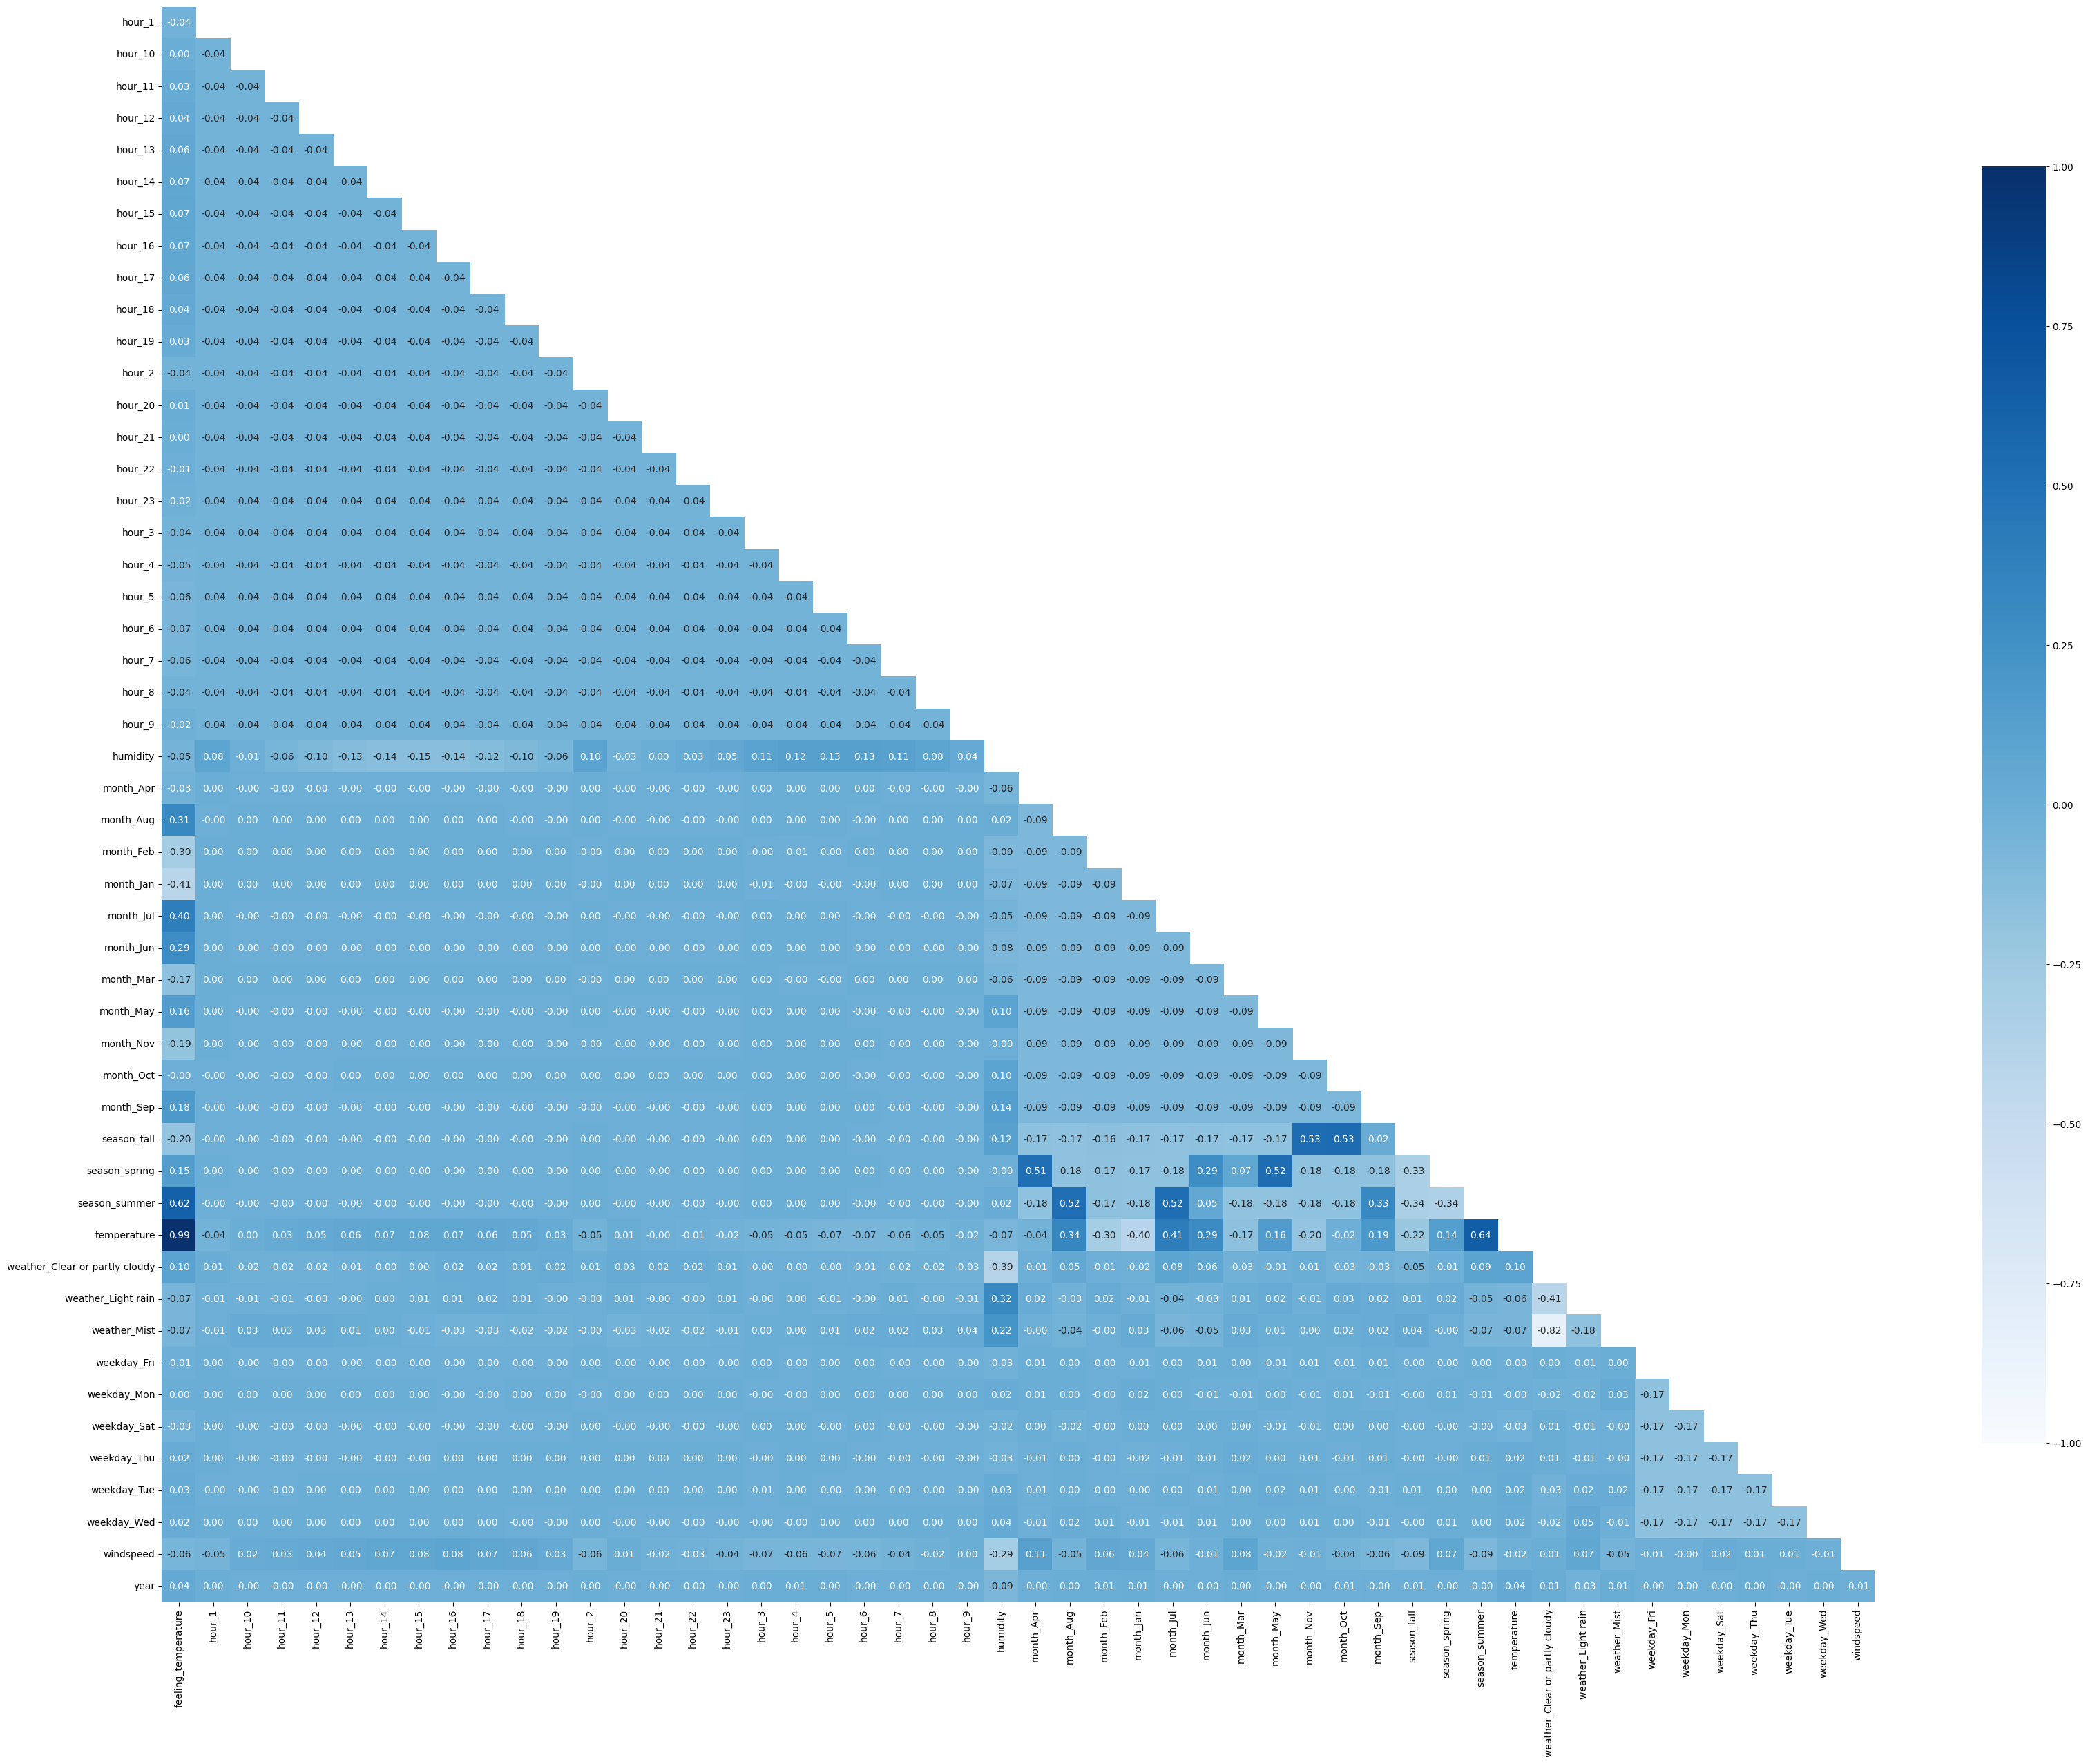

In [32]:
correlation_matrix = features_from(df_for_training).corr()
fig, ax = plt.subplots(figsize=(40, 30))
plot_correlation(correlation_matrix, ax)

### Remove feeling temperature because of high correlation with temperature

In [33]:
df_for_training.drop([FEELING_TEMPERATURE], axis=1, inplace=True)

input_df.drop([FEELING_TEMPERATURE], axis=1, inplace=True)

## Models

### Task A.3: Linear Regression

In [34]:
features = features_from(df_for_training)
total_rentals = total_rentals_from(df_for_training)

In [35]:
def evaluate(X, y, train_ratio):
  """
  Given a set of input features X, a set of outputs y, and the ratio train_ratio of the training set to the full
  set of data, this function splits the data into train and test sets according to train_ration, fits a linear
  regression model with the train set and returns the R-squared score obtained by compareing the true and predicted
  output values for the test set.
  """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - train_ratio),
                                                      random_state=0)
  regressor = LinearRegression()
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  y_train_pred = regressor.predict(X_train)
  return r2_score(y_test, y_pred), r2_score(y_train, y_train_pred)


Max R2 score 0.6869806012324817


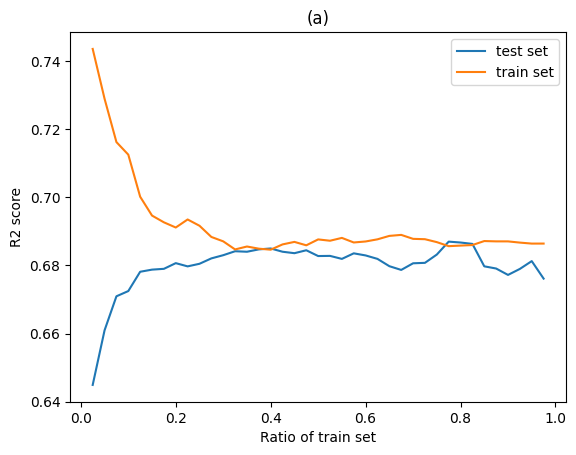

In [36]:
# Evaluating the R-squared score for various ratios of the training sat w.r.t. the full dataset
train_ratio_vals = []
r2_scores = []
r2_train_scores = []

for i in range(1, 40):
    train_ratio = i * 0.025
    train_ratio_vals.append(train_ratio)
    r2_test, r2_train = evaluate(features, total_rentals, train_ratio)
    r2_scores.append(r2_test)
    r2_train_scores.append(r2_train)

plt.plot(train_ratio_vals, r2_scores, label='test set')
plt.plot(train_ratio_vals, r2_train_scores, label='train set')
plt.xlabel('Ratio of train set')
plt.ylabel('R2 score')
plt.title('(a)')
plt.legend()

print("Max R2 score", max(r2_scores))

#### Transformations on the target values

<h3>Quantile Tranformer</h3>

In [37]:
def evaluate_quantile(X, y, train_ratio):
    """
    Given a set of input features X, a set of outputs y, and the ratio train_ratio of the training set to the full 
    set of data, this function splits the data into train and test sets according to train_ration, fits a linear
    regression model with the train set and returns the R-squared score obtained by compareing the true and predicted
    output values for the test set.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1-train_ratio),
                                                        random_state = 0)
    scaler = QuantileTransformer()
    y_train_trans = scaler.fit_transform(y_train)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train_trans)
    y_pred_trans = regressor.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_trans)
    y_train_pred_trans = regressor.predict(X_train)
    y_train_pred = scaler.inverse_transform(y_train_pred_trans)
    return r2_score(y_test, y_pred), r2_score(y_train, y_train_pred)

Max R2 score 0.6971985115880561


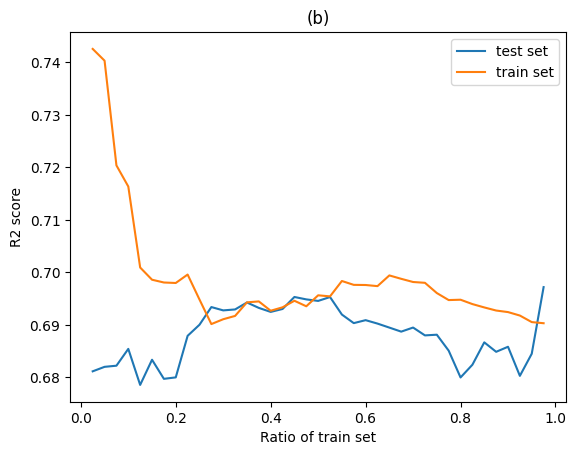

In [38]:
# Evaluating the R-squared score for various ratios of the training sat w.r.t. the full dataset

train_ratio_vals = []
r2_scores = []
r2_train_scores = []

for i in range(1, 40):
    train_ratio = i * 0.025
    train_ratio_vals.append(train_ratio)
    r2_test, r2_train = evaluate_quantile(features, total_rentals, train_ratio)
    r2_scores.append(r2_test)
    r2_train_scores.append(r2_train)
    
plt.plot(train_ratio_vals, r2_scores, label='test set')
plt.plot(train_ratio_vals, r2_train_scores, label='train set')
plt.xlabel('Ratio of train set')
plt.ylabel('R2 score')
plt.title('(b)')
plt.legend()

print("Max R2 score", max(r2_scores))

<h3>Log Transform</h3>

In [39]:
def evaluate_log(X, y, train_ratio):
    """
    Given a set of input features X, a set of outputs y, and the ratio train_ratio of the training set to the full 
    set of data, this function splits the data into train and test sets according to train_ration, fits a linear
    regression model with the train set and returns the R-squared score obtained by compareing the true and predicted
    output values for the test set.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1-train_ratio),
                                                        random_state = 0)
    y_train_trans = np.log10(y_train)
    y_t = np.power(10, y_train_trans)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train_trans)
    y_pred_trans = regressor.predict(X_test)
    y_pred = np.power(10, y_pred_trans)
    y_train_pred_trans = regressor.predict(X_train)
    y_train_pred = np.power(10, y_train_pred_trans)
    return r2_score(y_test, y_pred), r2_score(y_train, y_train_pred)

Max R2 score 0.7121966905873701


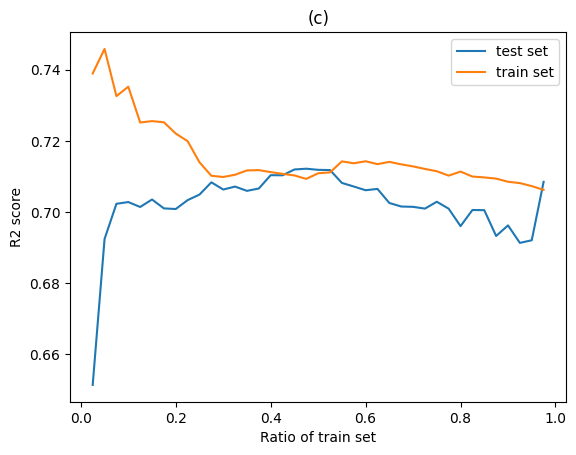

In [40]:
# Evaluating the R-squared score for various ratios of the training sat w.r.t. the full dataset

train_ratio_vals = []
r2_scores = []
r2_train_scores = []

for i in range(1, 40):
    train_ratio = i * 0.025
    train_ratio_vals.append(train_ratio)
    r2_test, r2_train = evaluate_log(features, total_rentals, train_ratio)
    r2_scores.append(r2_test)
    r2_train_scores.append(r2_train)
    
plt.plot(train_ratio_vals, r2_scores, label='test set')
plt.plot(train_ratio_vals, r2_train_scores, label='train set')
plt.xlabel('Ratio of train set')
plt.ylabel('R2 score')
plt.title('(c)')
plt.legend()

print("Max R2 score", max(r2_scores))

<h2>Power Transform</h2>

In [41]:
def evaluate_power(X, y, train_ratio):
    """
    Given a set of input features X, a set of outputs y, and the ratio train_ratio of the training set to the full 
    set of data, this function splits the data into train and test sets according to train_ration, fits a linear
    regression model with the train set and returns the R-squared score obtained by compareing the true and predicted
    output values for the test set.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1-train_ratio),
                                                        random_state = 0)
    scaler = PowerTransformer(method = 'yeo-johnson')
    y_train_trans = scaler.fit_transform(y_train)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train_trans)
    y_pred_trans = regressor.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_trans)
    y_train_pred_trans = regressor.predict(X_train)
    y_train_pred = scaler.inverse_transform(y_train_pred_trans)
    return r2_score(y_test, y_pred), r2_score(y_train, y_train_pred)

Max R2 score 0.733484938268856


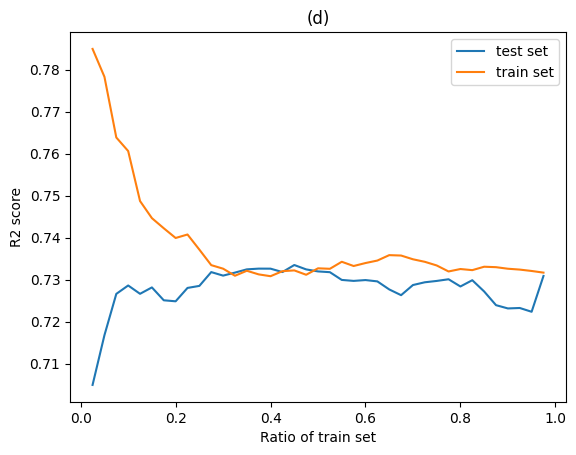

In [42]:
# Evaluating the R-squared score for various ratios of the training sat w.r.t. the full dataset

train_ratio_vals = []
r2_scores = []
r2_train_scores = []

for i in range(1, 40):
    train_ratio = i * 0.025
    train_ratio_vals.append(train_ratio)
    r2_test, r2_train_score = evaluate_power(features, total_rentals, train_ratio)
    r2_scores.append(r2_test)
    r2_train_scores.append(r2_train_score)

plt.plot(train_ratio_vals, r2_scores, label='test set')
plt.plot(train_ratio_vals, r2_train_scores, label='train set')
plt.xlabel('Ratio of train set')
plt.ylabel('R2 score')
plt.title('(d)')
plt.legend()

print("Max R2 score", max(r2_scores))

### Task A.4: Decision Trees

#### Split dataset to train and test set

In [43]:
features = features_from(df_for_training)
subscribed_rentals = subscribed_rentals_from(df_for_training)

X_train, X_test, y_train, y_test = train_test_split(
  features,
  subscribed_rentals,
  test_size=0.2,
  random_state=0
)

#### Experiments on parameter settings

In [44]:
@dataclass
class ExperimentResults():
  score: float
  train_score: float
  train_mse: dict
  test_mse: dict

In [45]:
def get_results_for(
    X_train,
    y_train,
    X_test,
    y_test,
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_leaf_nodes=None
    ):
  regressor = DecisionTreeRegressor(
      max_depth=max_depth, 
      min_samples_split=min_samples_split, 
      min_samples_leaf=min_samples_leaf, 
      max_leaf_nodes=max_leaf_nodes,
      random_state=42,
      )
  regressor.fit(X_train, y_train)
  return ExperimentResults(
      score=regressor.score(X_test,y_test),
      train_score=regressor.score(X_train, y_train),
      train_mse=mean_squared_error(y_train, regressor.predict(X_train)),
      test_mse=mean_squared_error(y_test, regressor.predict(X_test)),
  )

def train_mses_from(results_dict):
  return list(map(lambda x: x.train_mse, list(results_dict.values())))

def test_mses_from(results_dict):
  return list(map(lambda x: x.test_mse, list(results_dict.values())))

def scores_from(results_dict):
  return list(map(lambda x: x.score, list(results_dict.values())))

def train_scores_from(results_dict):
  return list(map(lambda x: x.train_score, list(results_dict.values())))

In [46]:
def plot_scores(x_label, x, results, ax):
  ax.set_title(f'Score per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('Score')
  ax.plot(x, scores_from(results))

def plot_train_scores(x_label, x, results, ax):
  ax.set_title(f'Train Score per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('Train Score')
  ax.plot(x, train_scores_from(results))

def plot_train_mses(x_label, x, results, ax):
  ax.set_title(f'Train MSE per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('Train MSE')
  ax.plot(x, train_mses_from(results))

def plot_test_mses(x_label, x, results, ax):
  ax.set_title(f'Test MSE per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('Test MSE')
  ax.plot(x, test_mses_from(results))

def plot_train_and_test_scores(x_label, x, results, ax):
  ax.set_title(f'Score per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('Score')
  ax.plot(x, scores_from(results), label='test set')
  ax.plot(x, train_scores_from(results), label='train set')
  ax.legend()

def plot_train_and_test_mses(x_label, x, results, ax):
  ax.set_title(f'MSE per {x_label}')
  ax.set_xlabel(x_label)
  ax.set_ylabel('MSE')
  ax.plot(x, test_mses_from(results), label='test set')
  ax.plot(x, train_mses_from(results), label='train set')
  ax.legend()

#### max depth

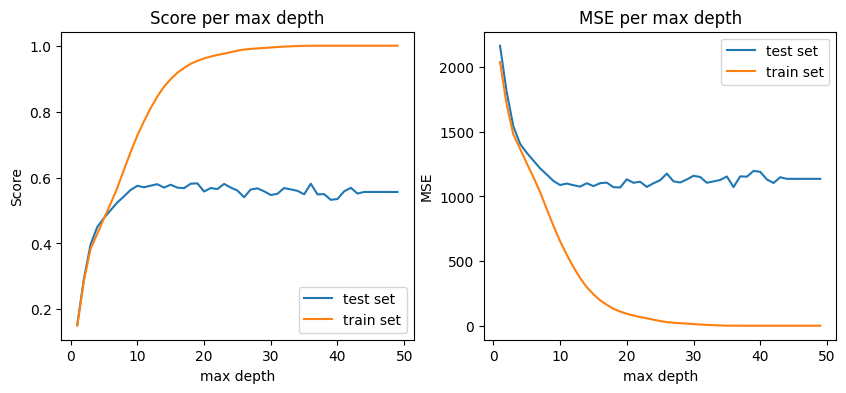

In [47]:
label = 'max depth'
max_depths = range(1,50)
results_per_max_depth = {}

for max_depth in max_depths:
  results = get_results_for(X_train, y_train, X_test, y_test, max_depth=max_depth)
  results_per_max_depth[max_depth] = results

fig, axs = plt.subplots(1,2, figsize=(10,4))
plot_train_and_test_scores(label, max_depths, results_per_max_depth, axs[0])
plot_train_and_test_mses(label, max_depths, results_per_max_depth, axs[1])

#### min samples split

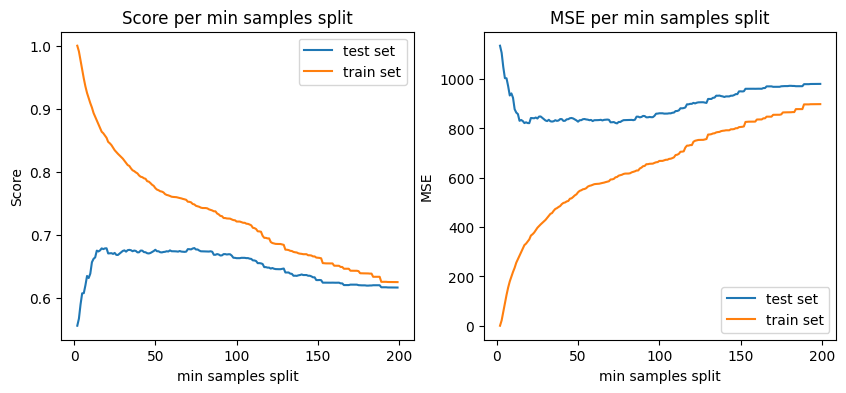

In [48]:
label = 'min samples split'
min_samples_splits = range(2, 200)
results_per_min_samples_split = {}

for min_samples_split in min_samples_splits:
  results = get_results_for(X_train, y_train, X_test, y_test, min_samples_split=min_samples_split)
  results_per_min_samples_split[min_samples_split] = results

fig, axs = plt.subplots(1,2, figsize=(10,4))
plot_train_and_test_scores(label, min_samples_splits, results_per_min_samples_split, axs[0])
plot_train_and_test_mses(label, min_samples_splits, results_per_min_samples_split, axs[1])

#### min samples leaf

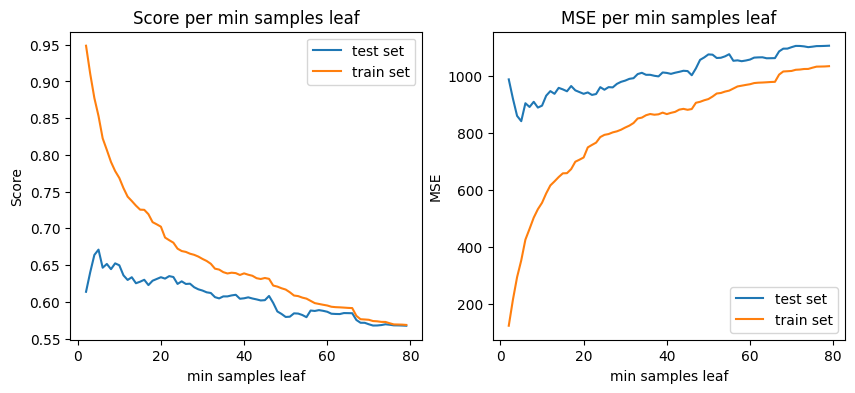

In [49]:
label = 'min samples leaf'
min_samples_leaves = range(2,80)
results_per_min_samples_leaf = {}

for min_samples_leaf in min_samples_leaves:
  results = get_results_for(X_train, y_train, X_test, y_test, min_samples_leaf=min_samples_leaf)
  results_per_min_samples_leaf[min_samples_leaf] = results

fig, axs = plt.subplots(1,2, figsize=(10,4))
plot_train_and_test_scores(label, min_samples_leaves, results_per_min_samples_leaf, axs[0])
plot_train_and_test_mses(label, min_samples_leaves, results_per_min_samples_leaf, axs[1])

#### max leaf nodes

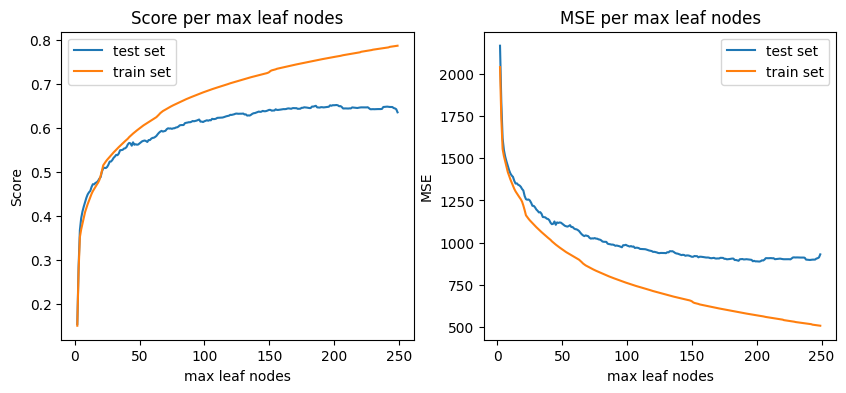

In [50]:
label = 'max leaf nodes'
max_leaf_nodes_range = range(2,250)
results_per_max_leaf_nodes = {}

for max_leaf_nodes in max_leaf_nodes_range:
  results = get_results_for(X_train, y_train, X_test, y_test, max_leaf_nodes=max_leaf_nodes)
  results_per_max_leaf_nodes[max_leaf_nodes] = results

fig, axs = plt.subplots(1,2, figsize=(10,4))

plot_train_and_test_scores(label, max_leaf_nodes_range, results_per_max_leaf_nodes, axs[0])
plot_train_and_test_mses(label, max_leaf_nodes_range, results_per_max_leaf_nodes, axs[1])


#### Applying best parameter settings on subscribers

In [51]:
results = get_results_for(
    X_train, 
    y_train, 
    X_test, 
    y_test,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    max_leaf_nodes=150
    )

print(f'Score: {results.score}')
print(f'MSE on train set: {results.train_mse}')
print(f'MSE on test set: {results.test_mse}')

Score: 0.6039293466068651
MSE on train set: 779.2257368798319
MSE on test set: 1013.5020482081936


#### Applying best parameter settings on non-subscribers

In [52]:
# Splitting dataset to train and test set
features = features_from(df_for_training)
non_subscribed_rentals = non_subscribed_rentals_from(df_for_training)

X_train, X_test, y_train, y_test = train_test_split(
  features,
  non_subscribed_rentals,
  test_size=0.2,
  random_state=0
)

In [53]:
# Training
results = get_results_for(
    X_train, 
    y_train, 
    X_test, 
    y_test,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    max_leaf_nodes=150
    )

print(f'Score: {results.score}')
print(f'MSE on train set: {results.train_mse}')
print(f'MSE on test set: {results.test_mse}')

Score: 0.6824198714387136
MSE on train set: 6416.805588798238
MSE on test set: 7346.904581784334


### Task B.1: Classification problem

In [54]:
def print_classification_results(clf, y_train, y_test, X_train, X_test):
  y_pred = clf.predict(X_test)
  y_train_pred = clf.predict(X_train)
  print(f'Train set:\n {classification_report(y_train, y_train_pred, labels=np.unique(y_train))}')
  print(f'Test set:\n {classification_report(y_test, y_pred, labels=np.unique(y_train))}')
  print(f'Train set score: {clf.score(X_train, y_train)}')
  print(f'Test set score: {clf.score(X_test, y_test)}')

Max total rentals value: Total    977
dtype: int64
Min total rentals value: Total    1
dtype: int64


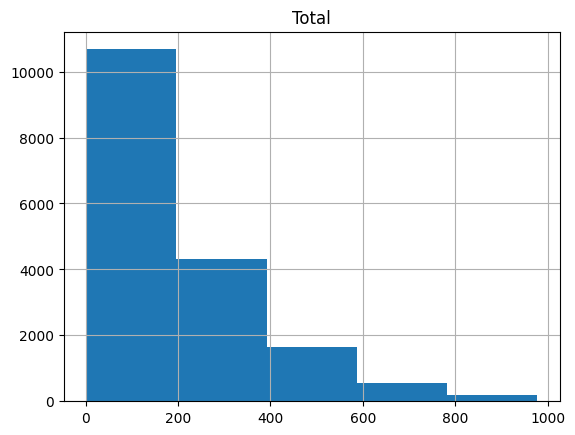

In [55]:
total_rentals.hist(bins=5)
print(f'Max total rentals value: {total_rentals.max()}')
print(f'Min total rentals value: {total_rentals.min()}')

In order to transform the regression problem to a classification problem with 5 classes, we are going to get 5 equally spaced bins, starting from the minimum value of the total rentals until the maximum value, and assign a class to each observation based on which bin it belongs.

#### Equally ranged classes

In [56]:
CLASSES = 5
CUT_BIN = 'cut_bin'
print(pd.cut(total_rentals[TOTAL], bins=CLASSES).value_counts())
total_rentals[CUT_BIN] = pd.cut(total_rentals[TOTAL], bins=CLASSES, labels=range(CLASSES))
total_rentals[CUT_BIN].value_counts()

(0.024, 196.2]    10677
(196.2, 391.4]     4319
(391.4, 586.6]     1650
(586.6, 781.8]      557
(781.8, 977.0]      176
Name: Total, dtype: int64


0    10677
1     4319
2     1650
3      557
4      176
Name: cut_bin, dtype: int64

In [57]:
print(features.columns)

Index(['hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'humidity',
       'month_Apr', 'month_Aug', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep', 'season_fall', 'season_spring', 'season_summer',
       'temperature', 'weather_Clear or partly cloudy', 'weather_Light rain',
       'weather_Mist', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'windspeed', 'year'],
      dtype='object')


In [58]:
y = total_rentals[CUT_BIN].astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

columns_to_be_scaled = [WINDSPEED, HUMIDITY, TEMPERATURE]
standardized_X_train = X_train.copy()
standardized_X_train[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_train[columns_to_be_scaled])
standardized_X_test = X_test.copy()
standardized_X_test[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_test[columns_to_be_scaled])

In [59]:
%%time 
one_vs_all_clf = OneVsRestClassifier(
    LogisticRegression(max_iter=10000, random_state=40)
    ).fit(standardized_X_train, y_train)

CPU times: user 3.06 s, sys: 1.48 s, total: 4.54 s
Wall time: 2.39 s


In [60]:
print_classification_results(one_vs_all_clf, y_train, y_test, standardized_X_train, standardized_X_test)

Train set:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      8486
           1       0.59      0.64      0.62      3463
           2       0.42      0.25      0.31      1363
           3       0.62      0.24      0.35       450
           4       0.80      0.46      0.59       141

    accuracy                           0.76     13903
   macro avg       0.66      0.50      0.55     13903
weighted avg       0.74      0.76      0.74     13903

Test set:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      2191
           1       0.61      0.64      0.63       856
           2       0.41      0.31      0.35       287
           3       0.64      0.20      0.30       107
           4       0.86      0.51      0.64        35

    accuracy                           0.77      3476
   macro avg       0.68      0.52      0.56      3476
weighted avg       0.76      0.77      0.76      3476


In [61]:
%%time 
one_vs_one_clf = OneVsOneClassifier(
    LogisticRegression(max_iter=10000, random_state=42)
    ).fit(standardized_X_train, y_train)

CPU times: user 1.96 s, sys: 1.07 s, total: 3.03 s
Wall time: 1.59 s


In [62]:
print_classification_results(one_vs_one_clf, y_train, y_test, standardized_X_train, standardized_X_test)

Train set:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      8486
           1       0.65      0.67      0.66      3463
           2       0.53      0.43      0.47      1363
           3       0.55      0.44      0.49       450
           4       0.72      0.65      0.68       141

    accuracy                           0.78     13903
   macro avg       0.67      0.62      0.64     13903
weighted avg       0.78      0.78      0.78     13903

Test set:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      2191
           1       0.65      0.67      0.66       856
           2       0.51      0.48      0.50       287
           3       0.61      0.47      0.53       107
           4       0.82      0.66      0.73        35

    accuracy                           0.79      3476
   macro avg       0.70      0.64      0.66      3476
weighted avg       0.79      0.79      0.79      3476


#### Balanced classes

In [63]:
QCUT_BIN = 'qcut_bin' 
print(pd.qcut(total_rentals[TOTAL], q=CLASSES).value_counts())
total_rentals[QCUT_BIN] = pd.qcut(total_rentals[TOTAL], q=CLASSES, labels=range(CLASSES))
total_rentals[QCUT_BIN].value_counts()

(0.999, 27.0]     3538
(98.0, 189.0]     3472
(321.0, 977.0]    3471
(189.0, 321.0]    3464
(27.0, 98.0]      3434
Name: Total, dtype: int64


0    3538
2    3472
4    3471
3    3464
1    3434
Name: qcut_bin, dtype: int64

In [64]:
y = total_rentals[QCUT_BIN].astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

columns_to_be_scaled = [WINDSPEED, HUMIDITY, TEMPERATURE]
standardized_X_train = X_train.copy()
standardized_X_train[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_train[columns_to_be_scaled])
standardized_X_test = X_test.copy()
standardized_X_test[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_test[columns_to_be_scaled])

In [65]:
%%time 
one_vs_all_clf = OneVsRestClassifier(
    LogisticRegression(max_iter=10000, random_state=42)
    ).fit(standardized_X_train, y_train)

print_classification_results(one_vs_all_clf, y_train, y_test, standardized_X_train, standardized_X_test)

Train set:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      2859
           1       0.52      0.45      0.48      2689
           2       0.52      0.43      0.47      2752
           3       0.52      0.55      0.53      2788
           4       0.67      0.78      0.72      2815

    accuracy                           0.61     13903
   macro avg       0.60      0.61      0.60     13903
weighted avg       0.60      0.61      0.60     13903

Test set:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       679
           1       0.54      0.43      0.48       745
           2       0.51      0.43      0.47       720
           3       0.50      0.56      0.53       676
           4       0.65      0.77      0.70       656

    accuracy                           0.60      3476
   macro avg       0.59      0.60      0.59      3476
weighted avg       0.59      0.60      0.59      3476


In [66]:
%%time 
one_vs_one_clf = OneVsOneClassifier(
    LogisticRegression(max_iter=10000, random_state=42)
    ).fit(standardized_X_train, y_train)
print_classification_results(one_vs_one_clf, y_train, y_test, standardized_X_train, standardized_X_test)

Train set:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      2859
           1       0.58      0.55      0.56      2689
           2       0.57      0.56      0.56      2752
           3       0.58      0.57      0.57      2788
           4       0.73      0.75      0.74      2815

    accuracy                           0.65     13903
   macro avg       0.65      0.65      0.65     13903
weighted avg       0.65      0.65      0.65     13903

Test set:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80       679
           1       0.60      0.55      0.57       745
           2       0.56      0.55      0.55       720
           3       0.56      0.55      0.56       676
           4       0.69      0.75      0.72       656

    accuracy                           0.64      3476
   macro avg       0.64      0.64      0.64      3476
weighted avg       0.64      0.64      0.64      3476


### Task B.2: Weather prediction with Perceptron

#### Prepare initial dataset for weather prediction

In [67]:
weather_features_df = df_for_training[
                pd.Index([TEMPERATURE, HUMIDITY, WINDSPEED, YEAR]).append(
                    df_for_training.columns[pd.Series(df_for_training.columns).str.startswith(HOUR)]
                    ).append(
                      df_for_training.columns[pd.Series(df_for_training.columns).str.startswith(WEEKDAY)]
                    ).append(
                      df_for_training.columns[pd.Series(df_for_training.columns).str.startswith(SEASON)]
                    ).append(
                      df_for_training.columns[pd.Series(df_for_training.columns).str.startswith(MONTH)]
                    )
                ]
print(f'Initial weather features:\n{weather_features_df.columns}\n')
print(f'Unique weather labels: {initial_df[WEATHER].unique()}')
label_enc = LabelEncoder()
label_enc.fit(initial_df[WEATHER])
print('\nClasses and labels:')
for i, cl in enumerate(label_enc.classes_):
  print(i, cl) 
weather_targets = label_enc.transform(initial_df[WEATHER])
print('\nOccurences of each class:')
initial_df[WEATHER].value_counts()

Initial weather features:
Index(['temperature', 'humidity', 'windspeed', 'year', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'season_fall',
       'season_spring', 'season_summer', 'month_Apr', 'month_Aug', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep'],
      dtype='object')

Unique weather labels: ['Clear or partly cloudy' 'Mist' 'Light rain' 'Heavy rain']

Classes and labels:
0 Clear or partly cloudy
1 Heavy rain
2 Light rain
3 Mist

Occurences of each class:


Clear or partly cloudy    11413
Mist                       4544
Light rain                 1419
Heavy rain                    3
Name: weather, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    weather_features_df, 
    weather_targets,
    test_size=0.2, 
    random_state=42
    )

columns_to_be_scaled = [WINDSPEED, HUMIDITY, TEMPERATURE]
standardized_X_train = X_train.copy()
standardized_X_train[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_train[columns_to_be_scaled])
standardized_X_test = X_test.copy()
standardized_X_test[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_test[columns_to_be_scaled])
standardized_X_train

,temperature,humidity,windspeed,year,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Thu,weekday_Tue,weekday_Wed,season_fall,season_spring,season_summer,month_Apr,month_Aug,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
335,-1.551679,-0.405447,0.289745,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7035,0.117983,-1.084747,-0.705173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8051,-0.195079,1.945975,0.289745,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2133,-0.195079,-1.659539,-1.575935,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
8485,-1.551679,0.639629,-0.705173,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.195079,1.318929,-0.829330,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
11964,0.848460,-1.502778,-0.456860,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
5390,1.578937,-1.032493,0.787204,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
860,-1.342971,0.117091,1.906279,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Train Perceptrion without feature selection

In [69]:
perceptron_clf = OneVsOneClassifier(
    Perceptron(random_state=42)
    ).fit(X_train, y_train)
print_classification_results(perceptron_clf, y_train, y_test, X_train, X_test)

Train set:
               precision    recall  f1-score   support

           0       0.66      1.00      0.79      9115
           1       0.00      0.00      0.00         2
           2       1.00      0.00      0.00      1131
           3       0.00      0.00      0.00      3655

    accuracy                           0.66     13903
   macro avg       0.41      0.25      0.20     13903
weighted avg       0.51      0.66      0.52     13903

Test set:
               precision    recall  f1-score   support

           0       0.66      1.00      0.80      2298
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       288
           3       0.00      0.00      0.00       889

    accuracy                           0.66      3476
   macro avg       0.17      0.25      0.20      3476
weighted avg       0.44      0.66      0.53      3476

Train set score: 0.6556858232036251
Test set score: 0.6611047180667434


In [70]:
perceptron_clf = OneVsOneClassifier(
    Perceptron(tol=1e-3, random_state=42)
    ).fit(standardized_X_train, y_train)
print_classification_results(perceptron_clf, y_train, y_test, standardized_X_train, standardized_X_test)

Train set:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81      9115
           1       0.00      0.00      0.00         2
           2       0.39      0.36      0.37      1131
           3       0.42      0.17      0.25      3655

    accuracy                           0.67     13903
   macro avg       0.39      0.36      0.36     13903
weighted avg       0.62      0.67      0.63     13903

Test set:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      2298
           1       0.00      0.00      0.00         1
           2       0.36      0.32      0.34       288
           3       0.37      0.16      0.22       889

    accuracy                           0.67      3476
   macro avg       0.37      0.35      0.34      3476
weighted avg       0.61      0.67      0.63      3476

Train set score: 0.6727325037761634
Test set score: 0.6708860759493671


#### Apply feature selection

##### Select k-best

In [71]:
standardized_X_train.columns

Index(['temperature', 'humidity', 'windspeed', 'year', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'season_fall',
       'season_spring', 'season_summer', 'month_Apr', 'month_Aug', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep'],
      dtype='object')

In [72]:
discrete_feat_idx = list(range(3, len(standardized_X_train.columns)))
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
np.random.seed(42)

f1_train_scores = {}
f1_scores = {}
k_selected_features = {}
features_scores = {}

for random_state in range(0,10):
  for k in range(1, standardized_X_train.shape[1]+1):
    selector = SelectKBest(score_func, k=k)
    selector.fit(standardized_X_train, y_train)
    k_selected_features[k] = standardized_X_train.columns[selector.get_support()]
    features_scores[k] = selector.scores_
    
    selected_standardized_X_train = standardized_X_train[standardized_X_train.columns[selector.get_support()]]
    selected_standardized_X_test = standardized_X_test[standardized_X_test.columns[selector.get_support()]]
    clf = OneVsOneClassifier(
        Perceptron(random_state=random_state)
        ).fit(selected_standardized_X_train, y_train)
    
    y_train_pred = clf.predict(selected_standardized_X_train)
    y_pred = clf.predict(selected_standardized_X_test)

    if k not in f1_scores:
      f1_scores[k] = 0
      f1_train_scores[k] = 0
    f1_scores[k] += f1_score(y_test, y_pred, average='weighted')
    f1_train_scores[k] += f1_score(y_train, y_train_pred, average='weighted')

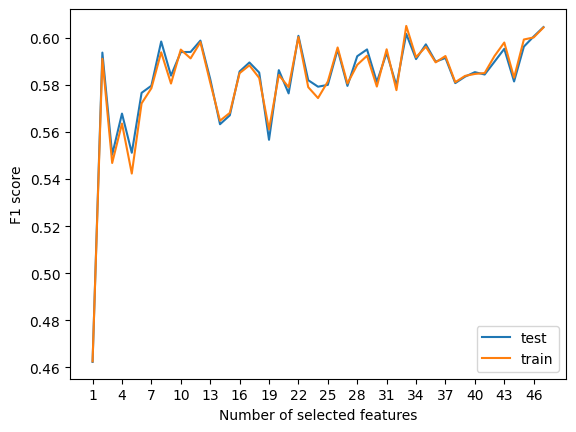

In [73]:
num_of_features = list(f1_scores.keys())
f1_score_values = [s/(10.0) for s in list(f1_scores.values())]
f1_train_score_values = [s/10.0 for s in list(f1_train_scores.values())]

plt.plot(num_of_features, f1_score_values, label='test')
plt.xticks(num_of_features[::3])
plt.plot(num_of_features, f1_train_score_values, label='train')
plt.xlabel('Number of selected features')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [74]:
f1_score_values

[0.4623243092089181,
 0.5937477598604606,
 0.5503662301348785,
 0.5678326375565305,
 0.5511869458265044,
 0.5766437492386471,
 0.5796732278072334,
 0.5984586003757185,
 0.5839584721922109,
 0.5939766911975545,
 0.5940131508407323,
 0.5988419839312543,
 0.5825482532752813,
 0.5633099002606027,
 0.5671040345212086,
 0.5857379601036627,
 0.589549077862075,
 0.5852495097886721,
 0.5567026928146196,
 0.5862959857888603,
 0.5764123989496065,
 0.6008778209324711,
 0.5820232485798303,
 0.5792575127416684,
 0.5800356371358599,
 0.5950518243211349,
 0.5795960310076673,
 0.5922095017493889,
 0.5950923898907663,
 0.5812637162887611,
 0.5936150197838553,
 0.5797228695196207,
 0.601689487357599,
 0.5909920280478869,
 0.5972488773140888,
 0.5898956730014893,
 0.5914642370350762,
 0.5807800459576471,
 0.583530670208812,
 0.5854418013642533,
 0.5844391572653111,
 0.5898670333832222,
 0.5953353735455613,
 0.5814816750916554,
 0.5962930085924011,
 0.6005830336124403,
 0.6045930546236313]

In [75]:
k_selected_features[8]

Index(['temperature', 'humidity', 'windspeed', 'weekday_Wed', 'season_fall',
       'season_summer', 'month_Jul', 'month_Jun'],
      dtype='object')

#### Impact of learning rate on binary classifier between 'Mist' and 'Light rain'

In [76]:
LIGHT_RAIN_ID = 2
MIST_ID = 3
weather_features_and_targets = pd.concat([
                                          weather_features_df[k_selected_features[8]], 
                                          pd.DataFrame(weather_targets, columns=[WEATHER])
                                          ], axis=1)
weather_features_and_targets = weather_features_and_targets[
                                  weather_features_and_targets[WEATHER].isin([LIGHT_RAIN_ID, MIST_ID])
                                ]

weather_features_and_targets.weather[weather_features_and_targets.weather == LIGHT_RAIN_ID] = 0
weather_features_and_targets.weather[weather_features_and_targets.weather == MIST_ID] = 1

X_train, X_test, y_train, y_test = train_test_split(
    weather_features_and_targets.drop(WEATHER, axis=1), 
    weather_features_and_targets[WEATHER],
    test_size=0.2, 
    random_state=42
    )

columns_to_be_scaled = [WINDSPEED, HUMIDITY, TEMPERATURE]
standardized_X_train = X_train.copy()
standardized_X_train[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_train[columns_to_be_scaled])
standardized_X_test = X_test.copy()
standardized_X_test[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_test[columns_to_be_scaled])


In [77]:
f1_scores = {}
f1_train_scores = {}
train_loss = {}
test_loss = {}

for random_state in range(100, 110):
  for learning_rate in np.linspace(1e-3, 1, num=20, endpoint=True):
    perceptron_clf = Perceptron(eta0=learning_rate, random_state=random_state)
    perceptron_clf.fit(standardized_X_train, y_train)
    
    if learning_rate not in f1_scores:
      f1_scores[learning_rate] = 0
      f1_train_scores[learning_rate] = 0
      test_loss[learning_rate] = 0
      train_loss[learning_rate] = 0

    f1_scores[learning_rate] += f1_score(y_test, perceptron_clf.predict(standardized_X_test), average='weighted')
    f1_train_scores[learning_rate] += f1_score(y_train, perceptron_clf.predict(standardized_X_train), average='weighted')
    test_loss[learning_rate] += log_loss(y_test, perceptron_clf.predict(standardized_X_test), labels=[0,1])
    train_loss[learning_rate] += log_loss(y_train, perceptron_clf.predict(standardized_X_train), labels=[0,1])
    

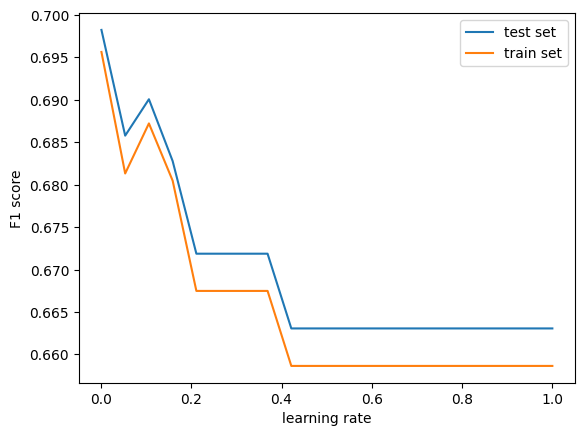

In [78]:
f1_score_values = [s/10.0 for s in list(f1_scores.values())]
f1_train_score_values = [s/10.0 for s in list(f1_train_scores.values())]

plt.plot(list(f1_scores.keys()), f1_score_values, label='test set')
plt.plot(list(f1_train_scores.keys()), f1_train_score_values, label='train set')
plt.xlabel('learning rate')
plt.ylabel('F1 score')
plt.legend()
plt.show()

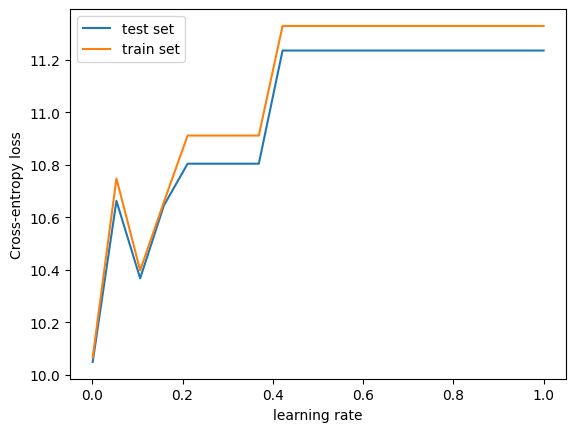

In [79]:
test_losses = [s/10.0 for s in list(test_loss.values())]
train_losses = [s/10.0 for s in list(train_loss.values())]

plt.plot(list(test_loss.keys()), test_losses, label='test set')
plt.plot(list(train_loss.keys()), train_losses, label='train set')
plt.xlabel('learning rate')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

### Task B.4: SVM Regressor

In [80]:
x = df_for_training.drop(['Non-subscribed', 'Total', 'Subscribed'], axis=1)
y = np.array(df_for_training[['Subscribed']])
y_scaled = StandardScaler().fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 100)

# All possible SVR kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = ['l_svm', 'poly_svm', 'rbf_svm', 'sig_svm']

# Save cv scores
cv_scores = {}
# Save test set acc scores
tts_scores = {}

for i in range(4):
    models[i] = make_pipeline(StandardScaler(), SVR(kernel = kernels[i]))
    cv_scores[kernels[i]] = np.mean(cross_val_score(models[i], x, y_scaled.ravel(), cv=5))
    #tts_scores[kernels[i]] = models[i].fit(x_train, y_train).score(x_test, y_test)
    
# Add cross validation scores to dataframe    
cv_df = pd.DataFrame.from_dict(cv_scores, orient='index')
cv_df = cv_df.reset_index()
cv_df = cv_df.rename(columns={"index": "Kernel", 0: "Accuracy"})

In [81]:
# Mean accuracy over 5-fold cross validation per used kernel
cv_df

,Kernel,Accuracy
0,linear,0.399564
1,poly,0.716216
2,rbf,0.725927
3,sigmoid,-74.227264


### Task B.5: PCA 

For this task, we'll used the uncapped input data (<i>input_df</i>). PCA is affected by scale, so we first need to standardize the data by applying a StandardScaler to sclae the data to unit scale (mean=0, variance=1). Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60.

In [82]:
X = features_from(input_df)
y_total = total_rentals_from(input_df)
y_subscribed = subscribed_rentals_from(input_df)
y_non_subscribed = non_subscribed_rentals_from(input_df)

pd.set_option('display.max_columns', None)
X.head()

,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,humidity,month_Apr,month_Aug,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,season_fall,season_spring,season_summer,temperature,weather_Clear or partly cloudy,weather_Light rain,weather_Mist,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Thu,weekday_Tue,weekday_Wed,windspeed,year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.28,1,0,0,0,0,1,0,0,0,0.0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2.34,1,0,0,0,0,1,0,0,0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,80.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2.34,1,0,0,0,0,1,0,0,0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,75.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.28,1,0,0,0,0,1,0,0,0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,75.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.28,1,0,0,0,0,1,0,0,0,0.0,0


In [83]:
# Standardizing the features
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.208496,-0.208946,-0.208946,-0.209096,-0.209246,-0.209246,-0.209246,-0.209396,-0.209396,-0.209096,-0.209096,-0.207140,-0.209096,-0.209096,-0.209096,-0.209096,-0.204405,-0.204405,-0.207442,-0.208646,-0.208946,-0.208946,-0.208946,0.951252,-0.300232,-0.304539,-0.289161,3.340906,-0.306003,-0.300574,-0.304313,-0.306003,-0.300232,-0.301824,-0.300232,-0.567361,-0.583042,-0.590751,-1.344267,0.723006,-0.298177,-0.595006,-0.408659,-0.407892,2.432774,-0.407124,-0.405394,-0.407508,-1.578372,-1.005134
1,4.796264,-0.208946,-0.208946,-0.209096,-0.209246,-0.209246,-0.209246,-0.209396,-0.209396,-0.209096,-0.209096,-0.207140,-0.209096,-0.209096,-0.209096,-0.209096,-0.204405,-0.204405,-0.207442,-0.208646,-0.208946,-0.208946,-0.208946,0.899045,-0.300232,-0.304539,-0.289161,3.340906,-0.306003,-0.300574,-0.304313,-0.306003,-0.300232,-0.301824,-0.300232,-0.567361,-0.583042,-0.590751,-1.448882,0.723006,-0.298177,-0.595006,-0.408659,-0.407892,2.432774,-0.407124,-0.405394,-0.407508,-1.578372,-1.005134
2,-0.208496,-0.208946,-0.208946,-0.209096,-0.209246,-0.209246,-0.209246,-0.209396,-0.209396,-0.209096,-0.209096,4.827659,-0.209096,-0.209096,-0.209096,-0.209096,-0.204405,-0.204405,-0.207442,-0.208646,-0.208946,-0.208946,-0.208946,0.899045,-0.300232,-0.304539,-0.289161,3.340906,-0.306003,-0.300574,-0.304313,-0.306003,-0.300232,-0.301824,-0.300232,-0.567361,-0.583042,-0.590751,-1.448882,0.723006,-0.298177,-0.595006,-0.408659,-0.407892,2.432774,-0.407124,-0.405394,-0.407508,-1.578372,-1.005134
3,-0.208496,-0.208946,-0.208946,-0.209096,-0.209246,-0.209246,-0.209246,-0.209396,-0.209396,-0.209096,-0.209096,-0.207140,-0.209096,-0.209096,-0.209096,-0.209096,4.892239,-0.204405,-0.207442,-0.208646,-0.208946,-0.208946,-0.208946,0.638010,-0.300232,-0.304539,-0.289161,3.340906,-0.306003,-0.300574,-0.304313,-0.306003,-0.300232,-0.301824,-0.300232,-0.567361,-0.583042,-0.590751,-1.344267,0.723006,-0.298177,-0.595006,-0.408659,-0.407892,2.432774,-0.407124,-0.405394,-0.407508,-1.578372,-1.005134
4,-0.208496,-0.208946,-0.208946,-0.209096,-0.209246,-0.209246,-0.209246,-0.209396,-0.209396,-0.209096,-0.209096,-0.207140,-0.209096,-0.209096,-0.209096,-0.209096,-0.204405,4.892239,-0.207442,-0.208646,-0.208946,-0.208946,-0.208946,0.638010,-0.300232,-0.304539,-0.289161,3.340906,-0.306003,-0.300574,-0.304313,-0.306003,-0.300232,-0.301824,-0.300232,-0.567361,-0.583042,-0.590751,-1.344267,0.723006,-0.298177,-0.595006,-0.408659,-0.407892,2.432774,-0.407124,-0.405394,-0.407508,-1.578372,-1.005134


The code projects the original 50-dimensional data into 2 dimensions.

In [84]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_df = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
X_pca_df.head()

,principal component 1,principal component 2
0,-1.164214,-0.161455
1,-1.286214,-0.243450
2,-1.297472,-0.265530
3,-1.212659,-0.238406
4,-1.231536,-0.250359


It's nice to visualize the result in a 2D plot.

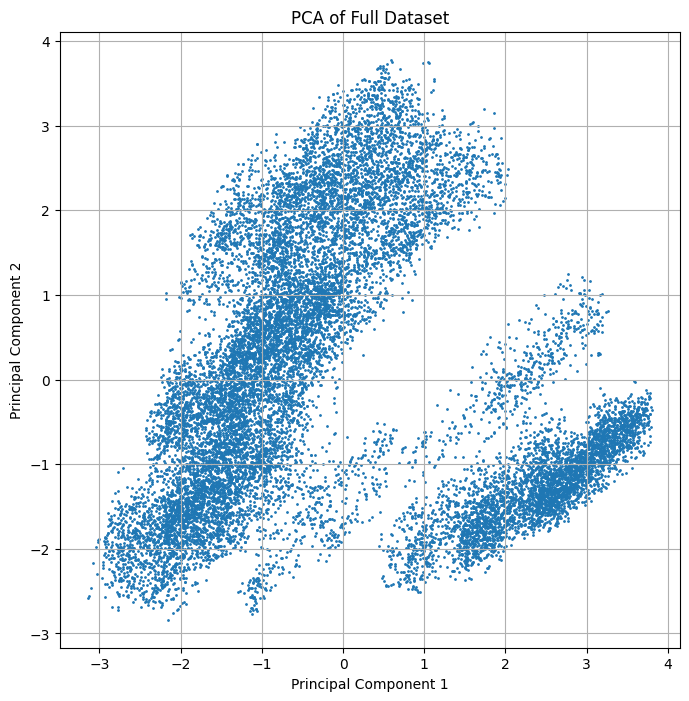

In [85]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Full Dataset')

ax.scatter(X_pca_df.loc[:, 'principal component 1'], X_pca_df.loc[:, 'principal component 2'], s=1)
ax.grid()

### Leaving out features before applying PCA

Now, we'd like to see the effect of removing each input feature before creating the PCA plot. We'll start out by creating 9 new datasets, each of them having one missing feature with respect to the original data used eariler in this task.

In [86]:
X_no_hour = features_from(input_df)
X_no_hour.drop([HOUR_1, HOUR_2, HOUR_3, HOUR_4, HOUR_5, HOUR_6, HOUR_7, HOUR_8, HOUR_9, HOUR_10, HOUR_11, HOUR_12, HOUR_13, HOUR_14, HOUR_15,HOUR_16, HOUR_17, HOUR_18,
                HOUR_19, HOUR_20, HOUR_21, HOUR_22, HOUR_23], axis=1, inplace=True)

X_no_humidity = features_from(input_df)
X_no_humidity.drop([HUMIDITY], axis=1, inplace=True)

X_no_month = features_from(input_df)
X_no_month.drop([MONTH_JAN, MONTH_FEB, MONTH_MAR, MONTH_APR, MONTH_MAY, MONTH_JUN, MONTH_JUL, MONTH_AUG, MONTH_SEP, MONTH_OCT, MONTH_NOV], axis=1, inplace=True)

X_no_season = features_from(input_df)
X_no_season.drop([SEASON_SPRING, SEASON_SUMMER, SEASON_FALL], axis=1, inplace=True)

X_no_temperature = features_from(input_df)
X_no_temperature.drop([TEMPERATURE], axis=1, inplace=True)

X_no_weather = features_from(input_df)
X_no_weather.drop([WEATHER_CLEAR_OR_CLOUDY, WEATHER_MIST, WEATHER_LIGHT_RAIN], axis=1, inplace=True)

X_no_weekday = features_from(input_df)
X_no_weekday.drop([WEEKDAY_MON, WEEKDAY_TUE, WEEKDAY_WED, WEEKDAY_THU, WEEKDAY_FRI, WEEKDAY_SAT], axis=1, inplace=True)

X_no_windspeed = features_from(input_df)
X_no_windspeed.drop([WINDSPEED], axis=1, inplace=True)

X_no_year = features_from(input_df)
X_no_year.drop([YEAR], axis=1, inplace=True)

A helper function for displaying the PCAs.

In [87]:
def plot_pca(X, fig, rows, cols, pos, feature):
  # Standardizing the features
  X = StandardScaler().fit_transform(X)
  X = pd.DataFrame(X)

  # PCA
  X_pca = pca.fit_transform(X)
  X_pca_df = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])

  # Plot
  ax = fig.add_subplot(rows, cols, pos) 
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_title('PCA of Dataset Excluding the ' + feature)
  ax.scatter(X_pca_df.loc[:, 'principal component 1'], X_pca_df.loc[:, 'principal component 2'], s=1)
  ax.grid()

Time to see the results.

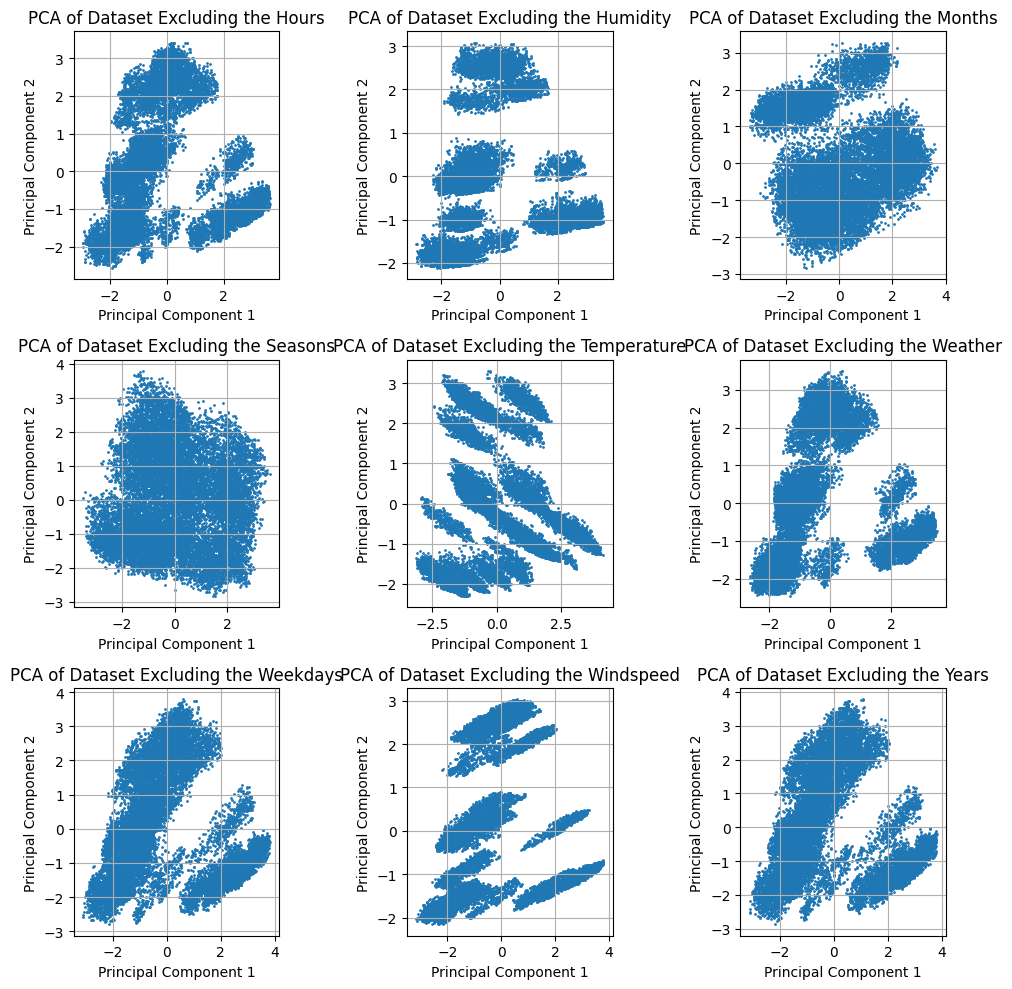

In [88]:
datasets = [X_no_hour, X_no_humidity, X_no_month, X_no_season, X_no_temperature, X_no_weather, X_no_weekday, X_no_windspeed, X_no_year]
features = ["Hours", "Humidity", "Months", "Seasons", "Temperature", "Weather", "Weekdays", "Windspeed", "Years"]
fig = plt.figure(figsize = (10, 10))

for i in range(9):
  plot_pca(datasets[i], fig, 3, 3, i+1, features[i])

fig.tight_layout()

### Task B.6: Hierarchical Clustering

We'll use a dendrogram to decide on the optimal number of clusters for the original data (only scaled).

Text(0, 0.5, 'Euclidean distances')

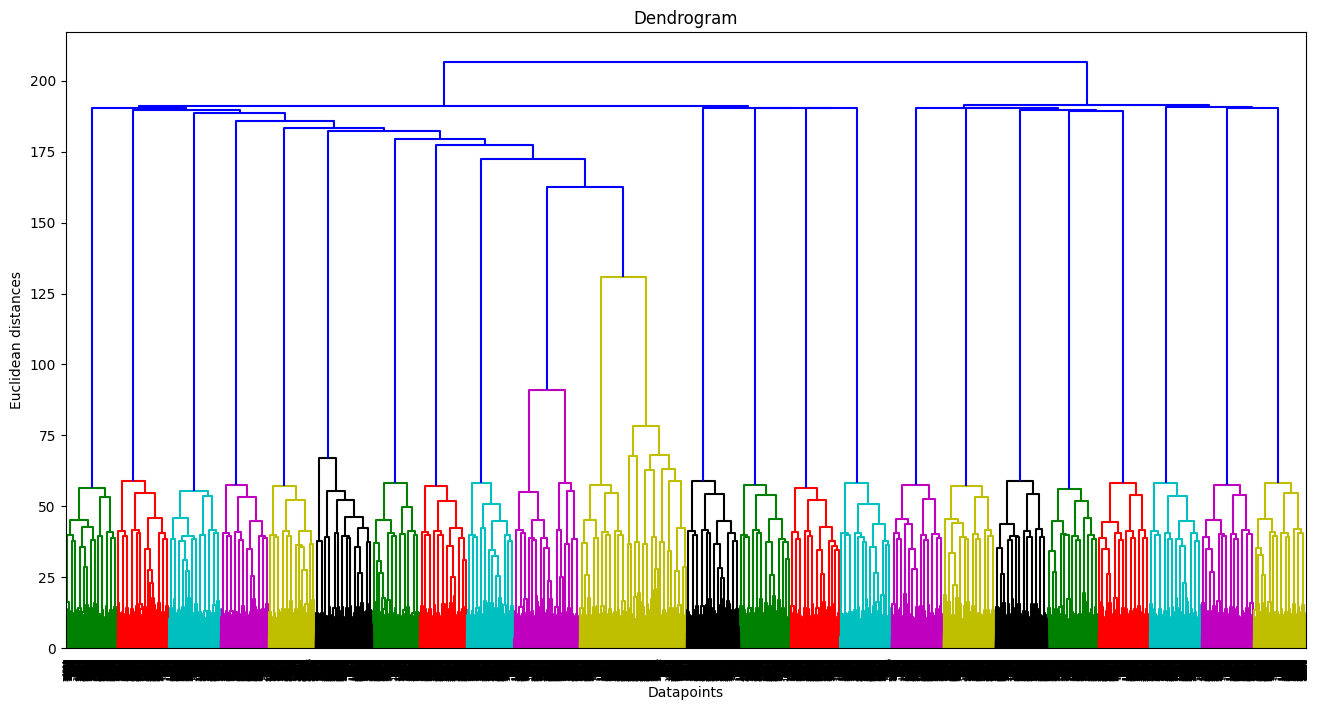

In [89]:

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1,1,1)
dendrogram = hierarchy.dendrogram(hierarchy.linkage(X, method = 'ward'))
ax.set_title('Dendrogram')
ax.set_xlabel('Datapoints')
ax.set_ylabel('Euclidean distances')

Judging by this dendrogram, the ideal number of clusters for us to use is 24. Let's see what are the 24 clusters we can find with Agglomerative Hierarchical Clustering. We will plot the results using PCA.

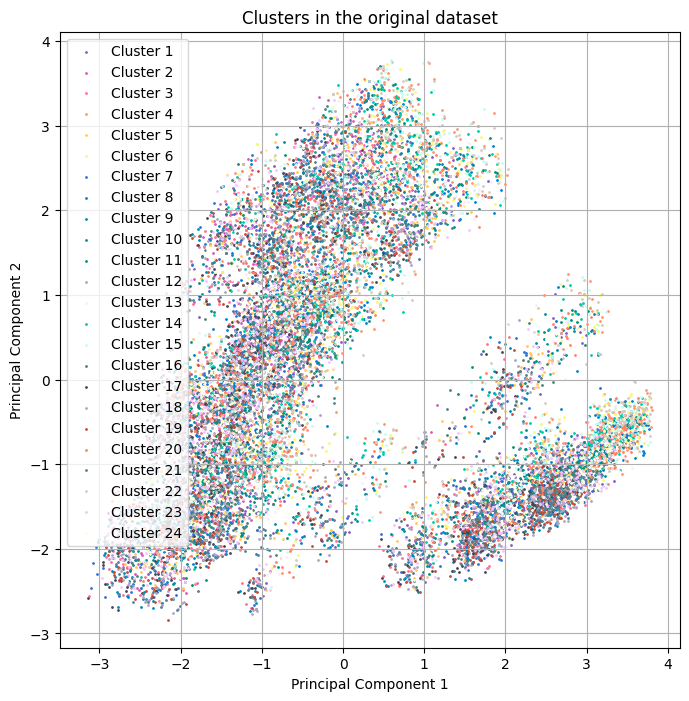

In [90]:

# Training the clustering model on the original data
ac = AgglomerativeClustering(n_clusters = 24, affinity = 'euclidean', linkage = 'ward')
y_ac = ac.fit_predict(X)

# Plotting the results using the PCA-transformed data
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
colors = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f', '#f9f871',
          '#2c73d2', '#0081cf', '#0089ba', '#008e9b', '#008f7a', '#b39cd0',
          '#fbeaff', '#00c9a7', '#c4fcef', '#4d8076', '#4b4453', '#b0a8b9',
          '#c34a36', '#ff8066', '#4e8397', '#d5cabd', '#f3c5ff', '#fefedf']

for i in range(24):
  ax.scatter(X_pca[y_ac == i, 0], X_pca[y_ac == i, 1], s = 1, c = colors[i], label = 'Cluster ' + str(i+1))

ax.set_title('Clusters in the original dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
ax.grid()

Now we will try performin Hierarchical Clustering on the PCA-transofrmed data. Let's see the plot with 24 clusters.

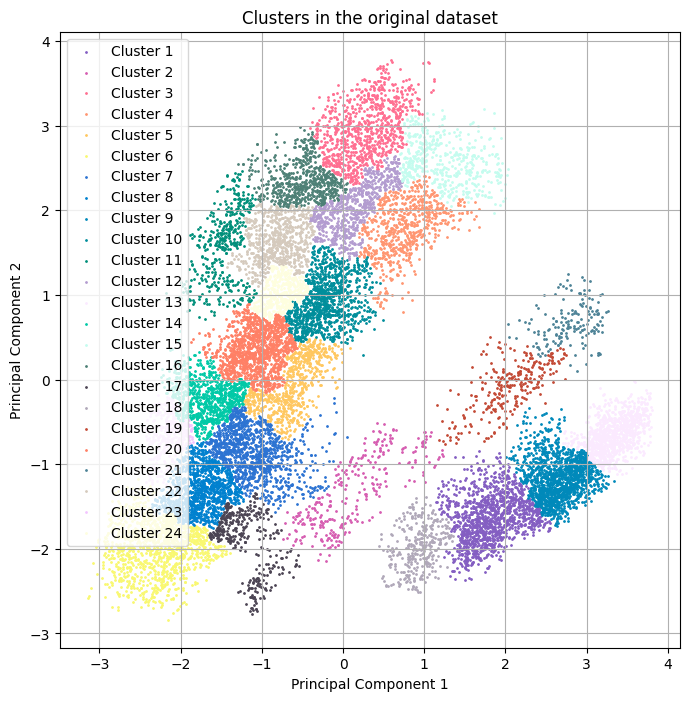

In [91]:
# Training the clustering model on the PCA-transformed data
ac = AgglomerativeClustering(n_clusters = 24, affinity = 'euclidean', linkage = 'ward')
y_ac = ac.fit_predict(X_pca)

# Plotting the results using the PCA-transformed data
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
colors = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f', '#f9f871',
          '#2c73d2', '#0081cf', '#0089ba', '#008e9b', '#008f7a', '#b39cd0',
          '#fbeaff', '#00c9a7', '#c4fcef', '#4d8076', '#4b4453', '#b0a8b9',
          '#c34a36', '#ff8066', '#4e8397', '#d5cabd', '#f3c5ff', '#fefedf']

for i in range(24):
  ax.scatter(X_pca[y_ac == i, 0], X_pca[y_ac == i, 1], s = 1, c = colors[i], label = 'Cluster ' + str(i+1))

ax.set_title('Clusters in the original dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
ax.grid()

Actually, the ideal number of clusters for the 2D PCA-transformed data might be different. Let's try to plot a dendrogram for it as well.

Text(0, 0.5, 'Euclidean distances')

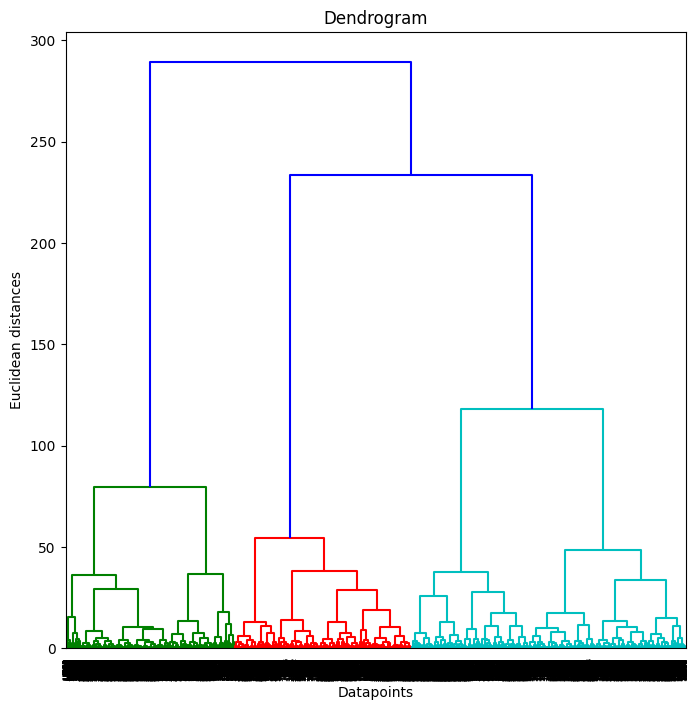

In [92]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
dendrogram = hierarchy.dendrogram(hierarchy.linkage(X_pca, method = 'ward'))
ax.set_title('Dendrogram')
ax.set_xlabel('Datapoints')
ax.set_ylabel('Euclidean distances')

In this situation, the ideal number of clusters is 3. Now we can perform Hierarchical Clustering for this new number of clusters.

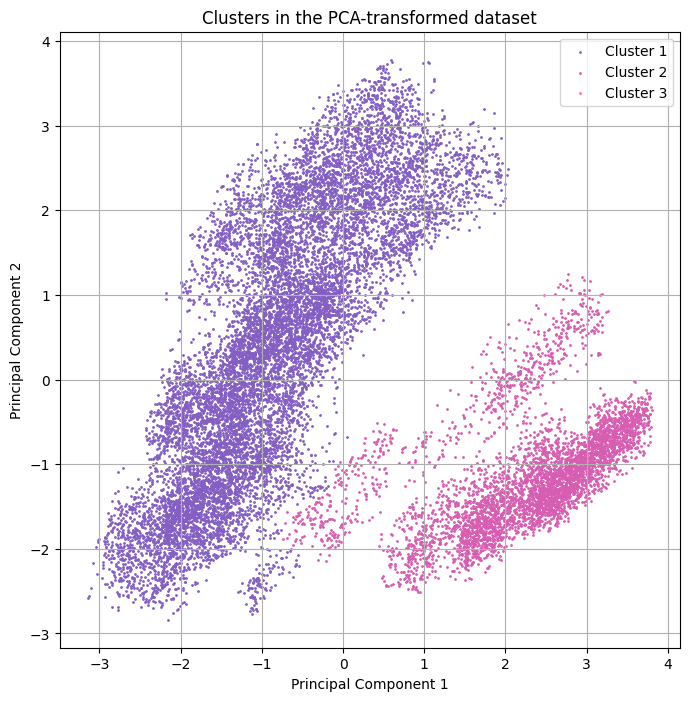

In [93]:
# Training the clustering model on the PCA-transformed data
ac = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_ac = ac.fit_predict(X_pca)

# Plotting the results using the PCA-transformed data
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
colors = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f', '#f9f871',
          '#2c73d2', '#0081cf', '#0089ba', '#008e9b', '#008f7a', '#b39cd0',
          '#fbeaff', '#00c9a7', '#c4fcef', '#4d8076', '#4b4453', '#b0a8b9',
          '#c34a36', '#ff8066', '#4e8397', '#d5cabd', '#f3c5ff', '#fefedf']

for i in range(3):
  ax.scatter(X_pca[y_ac == i, 0], X_pca[y_ac == i, 1], s = 1, c = colors[i], label = 'Cluster ' + str(i+1))

ax.set_title('Clusters in the PCA-transformed dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
ax.grid()

### Task B.7: Random Forest

In [94]:
x_rf = df_for_training.drop(['Non-subscribed', 'Total', 'Subscribed'], axis=1)
y_rf = df_for_training['Total']

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state = 100)
x_train_rf, x_val_rf, y_train_rf, y_val_rf = train_test_split(x_train_rf, y_train_rf, test_size=0.2, random_state = 100)


x_tv = x_train_rf + x_val_rf

indices = [-1 if x in range(len(x_train_rf)) else 0 for x in range(len(x_tv))]
ps2 = PredefinedSplit(indices)

rf = RandomForestRegressor(random_state = 100, oob_score=True)

n_estimators = [150]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [100]
min_samples_split = [int(x) for x in np.linspace(2, 20, 20)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 20)]

bootstrap = [True]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# n_iter = 100. Total parameter combinations = 1200. So 100/1200 = 0.083 (8% search space).
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                                verbose=2, cv = ps2, n_jobs = -1, refit=True)
rf_random.fit(pd.concat([x_train_rf, x_val_rf]),pd.concat([y_train_rf, y_val_rf]))

# Best parameters
bp = rf_random.best_params_

# Set RF to best found parameters
rf.set_params(**bp)
rf.fit(x_train_rf, y_train_rf)

rf.score(x_test_rf, y_test_rf)
rf.score(x_test_rf, y_test_rf)

print('Best params, rs: ', rf_random.best_params_, ' \n')
print('Validation accuracy: ' + str(rf.score(x_val_rf, y_val_rf)))
print('Test accuracy: ' + str(rf.score(x_test_rf, y_test_rf)))
print('OOB score: ' + str(rf.oob_score_))



Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best params, rs:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}  

Validation accuracy: 0.8408440305432372
Test accuracy: 0.8376346517801063
OOB score: 0.8134105189209613


### Task B.8: Choosing a Predictor

In [96]:
X = df_for_training.drop(['Non-subscribed', 'Total', 'Subscribed'], axis=1)
y = df_for_training['Total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_be_scaled = [WINDSPEED, HUMIDITY, TEMPERATURE]
standardized_X_train = X_train.copy()
standardized_X_train[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_train[columns_to_be_scaled])
standardized_X_test = X_test.copy()
standardized_X_test[columns_to_be_scaled] = StandardScaler().fit_transform(standardized_X_test[columns_to_be_scaled])


In [97]:
mlp = MLPRegressor(
    max_iter=500, 
    activation='relu', 
    solver='adam', 
    early_stopping=True,
    random_state=42,
    )

parameter_space = {
    'hidden_layer_sizes': [(64,), (32,32), (64, 64)],
    'alpha': [1e-3, 1e-2, 1e-1, 0.2],
}

mlp_gs = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
mlp_gs.fit(standardized_X_train, y_train)


GridSearchCV(cv=5,
             estimator=MLPRegressor(early_stopping=True, max_iter=500,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2],
                         'hidden_layer_sizes': [(64,), (32, 32), (64, 64)]})

In [98]:
y_test_pred = mlp_gs.predict(standardized_X_test)
y_train_pred = mlp_gs.predict(standardized_X_train)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train R2 score: {train_r2}')
print(f'Test R2 score: {test_r2}')
print(f'Best parameters: {mlp_gs.best_params_}')

Train R2 score: 0.9522142332606556
Test R2 score: 0.9316868012808226
Best parameters: {'alpha': 0.2, 'hidden_layer_sizes': (64, 64)}
